# VN30 - XÂY DỰNG MÔ HÌNH DỰ ĐOÁN BIẾN MỤC TIÊU 

In [1]:
target_column = 'VCB_Lần cuối'

## 0. Nhập thư viện cần thiết


In [2]:
from __future__ import annotations  
import io
import os
import time
os.environ["LOKY_MAX_CPU_COUNT"] = "4"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
import time
import os
import re
import io

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go

# Scikit-learn - Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
# Scikit-learn - Dimensionality Reduction
from sklearn.decomposition import PCA

# Scikit-learn - Clustering
from sklearn.cluster import KMeans

# Scikit-learn - Model Selection
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.tree import plot_tree

# Scikit-learn - Regression Models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Scikit-learn - Metrics
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error,
    root_mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error,
    accuracy_score, 
    adjusted_rand_score, 
    normalized_mutual_info_score, 
    silhouette_score, 
    silhouette_samples
)
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

import lightgbm as lgb
# Statsmodels - Time Series Analysis
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR, ARDL
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ardl import ardl_select_order

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor

# TensorFlow/Keras - Deep Learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.optimizers import Adam
# Configuration
warnings.filterwarnings("ignore")
sns.set_palette("husl")

plt.style.use("seaborn-v0_8")
plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
)
%matplotlib inline
warnings.filterwarnings("ignore")
warnings.filterwarnings('ignore', category=DeprecationWarning)

## 1. Đọc file VCB (biến mục tiêu) và gộp tất cả dữ liệu


In [3]:
COLS = ['Lần cuối', 'Mở', 'Cao', 'Thấp', 'KL', '% Thay đổi']

def process_df(df, symbol):
    """Xử lý và trộn dữ liệu"""
    df['Ngày'] = pd.to_datetime(df['Ngày'], dayfirst=True, errors='coerce')
    df = df.dropna(subset=['Ngày']).sort_values('Ngày').sample(frac=1, random_state=42).reset_index(drop=True)

    for c in ['Lần cuối', 'Mở', 'Cao', 'Thấp']:
        if c in df:
            df[c] = df[c].astype(str).str.replace(',', '').astype(float, errors='ignore')
    
    if 'KL' in df:
        v = df['KL'].astype(str).str.replace(',', '').str.replace('−', '-').str.extract(r'(-?\d+(?:\.\d+)?)([KMB])?', flags=re.IGNORECASE)
        df['KL'] = v[0].astype(float, errors='ignore') * v[1].fillna('').str.upper().replace({'': 1, 'K': 1e3, 'M': 1e6, 'B': 1e9})
    
    if '% Thay đổi' in df:
        df['% Thay đổi'] = df['% Thay đổi'].astype(str).str.replace(',', '').str.replace('%', '').str.replace('−', '-').astype(float, errors='ignore')
    
    return df.rename(columns={c: f'{symbol}_{c}' for c in COLS if c in df.columns})

final_df = process_df(pd.read_csv('data/VCB.csv'), 'VCB')
for f in sorted(os.listdir('data/')):
    if f.endswith('.csv') and f != 'VCB.csv':
        try:
            final_df = final_df.merge(process_df(pd.read_csv(f'data/{f}'), f[:-4]), on='Ngày', how='outer')
        except:
            pass

final_df = final_df.sort_values('Ngày').reset_index(drop=True)
print(f"Shape: {final_df.shape}")

Shape: (1427, 187)


## 2. Thực hiện thống kê mô tả dữ liệu (head(), tail(), info(), describe()) 

In [4]:
final_df.head()

,Ngày,VCB_Lần cuối,VCB_Mở,VCB_Cao,VCB_Thấp,VCB_KL,VCB_% Thay đổi,ACB_Lần cuối,ACB_Mở,ACB_Cao,...,VPB_Cao,VPB_Thấp,VPB_KL,VPB_% Thay đổi,VRE_Lần cuối,VRE_Mở,VRE_Cao,VRE_Thấp,VRE_KL,VRE_% Thay đổi
0,2020-01-02,69728.0,69267.0,70189.0,68883.0,492910.0,0.67,11323.1,11224.6,11323.1,...,7666.8,7426.0,4650000.0,2.75,34350.0,33800.0,34450.0,33800.0,581190.0,1.03
1,2020-01-03,69037.0,70265.0,70496.0,69037.0,684100.0,-0.99,11323.1,11323.1,11421.5,...,7759.3,7537.1,3820000.0,-0.73,34600.0,34300.0,34650.0,34100.0,1270000.0,0.73
2,2020-01-06,67194.0,68499.0,68730.0,67194.0,1120000.0,-2.67,11076.9,11323.1,11323.1,...,7537.1,7389.0,4470000.0,-2.20,33650.0,34500.0,34500.0,33500.0,682790.0,-2.75
3,2020-01-07,67424.0,66810.0,67501.0,65581.0,1290000.0,0.34,11076.9,11076.9,11175.4,...,7537.1,7407.5,3510000.0,2.00,33950.0,33650.0,33950.0,33600.0,356780.0,0.89
4,2020-01-08,66810.0,66733.0,67501.0,66195.0,921630.0,-0.91,10880.0,11076.9,11076.9,...,7537.1,7370.5,6530000.0,-1.23,32700.0,33400.0,33500.0,32600.0,919210.0,-3.68


In [5]:
final_df.tail()

,Ngày,VCB_Lần cuối,VCB_Mở,VCB_Cao,VCB_Thấp,VCB_KL,VCB_% Thay đổi,ACB_Lần cuối,ACB_Mở,ACB_Cao,...,VPB_Cao,VPB_Thấp,VPB_KL,VPB_% Thay đổi,VRE_Lần cuối,VRE_Mở,VRE_Cao,VRE_Thấp,VRE_KL,VRE_% Thay đổi
1422,2025-09-16,65600.0,66000.0,66600.0,65600.0,6770000.0,-0.30,26400.0,26600.0,26600.0,...,32850.0,31500.0,70210000.0,0.48,30600.0,30950.0,31100.0,30600.0,2800000.0,-0.16
1423,2025-09-17,64800.0,65500.0,65800.0,64800.0,5630000.0,-1.22,26150.0,26400.0,26450.0,...,31950.0,31000.0,26680000.0,-2.21,30200.0,30550.0,30900.0,30200.0,4130000.0,-1.31
1424,2025-09-18,63900.0,64900.0,64900.0,63600.0,8780000.0,-1.39,25550.0,26200.0,26200.0,...,31250.0,30300.0,26650000.0,-0.65,30200.0,30050.0,31500.0,30050.0,6790000.0,0.00
1425,2025-09-19,63000.0,64200.0,64500.0,63000.0,6930000.0,-1.41,25350.0,25800.0,25800.0,...,30950.0,30000.0,28450000.0,-1.30,29450.0,30300.0,30600.0,29450.0,7320000.0,-2.48
1426,2025-09-22,62900.0,63000.0,63200.0,62600.0,921100.0,-0.16,25350.0,25450.0,25450.0,...,30400.0,29750.0,10200000.0,-1.81,29400.0,29600.0,29700.0,29400.0,697800.0,-0.17


In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1427 entries, 0 to 1426
Columns: 187 entries, Ngày to VRE_% Thay đổi
dtypes: datetime64[ns](1), float64(186)
memory usage: 2.0 MB


In [7]:
final_df.describe()

,Ngày,VCB_Lần cuối,VCB_Mở,VCB_Cao,VCB_Thấp,VCB_KL,VCB_% Thay đổi,ACB_Lần cuối,ACB_Mở,ACB_Cao,...,VPB_Cao,VPB_Thấp,VPB_KL,VPB_% Thay đổi,VRE_Lần cuối,VRE_Mở,VRE_Cao,VRE_Thấp,VRE_KL,VRE_% Thay đổi
count,1427,1427.000000,1427.000000,1427.000000,1427.000000,1.427000e+03,1427.000000,1422.000000,1422.000000,1422.000000,...,1427.000000,1427.000000,1.427000e+03,1427.000000,1427.000000,1427.000000,1427.000000,1427.000000,1.427000e+03,1427.000000
mean,2022-11-11 10:26:39.439383296,75815.144359,75816.801682,76611.053959,75027.797477,1.898481e+06,0.012432,20857.472925,20862.624754,21090.107103,...,17999.248213,17496.157323,2.152720e+07,0.122186,26720.777856,26714.225648,27131.814996,26307.708479,5.625640e+06,0.017015
min,2020-01-02 00:00:00,43925.000000,43925.000000,44847.000000,43465.000000,1.744000e+05,-33.110000,8763.100000,7926.200000,9255.400000,...,6481.600000,5926.000000,1.670000e+06,-7.000000,16100.000000,16200.000000,16400.000000,16100.000000,3.567800e+05,-6.990000
25%,2021-06-09 12:00:00,65389.000000,65500.000000,66195.000000,64675.500000,9.709800e+05,-0.735000,18014.000000,18014.000000,18196.000000,...,15996.500000,15430.800000,1.081000e+07,-0.890000,23850.000000,23900.000000,24300.000000,23475.000000,2.585000e+06,-1.155000
50%,2022-11-09 00:00:00,76103.000000,76103.000000,76877.000000,75251.000000,1.370000e+06,0.000000,21086.000000,21050.000000,21251.000000,...,18550.000000,18150.000000,1.614000e+07,0.000000,27450.000000,27450.000000,27850.000000,27050.000000,4.520000e+06,0.000000
75%,2024-04-15 12:00:00,87174.000000,87000.000000,87853.500000,86200.000000,1.960000e+06,0.770000,25000.000000,25000.000000,25200.000000,...,20091.750000,19594.000000,2.414500e+07,1.085000,29850.000000,29750.000000,30300.000000,29250.000000,7.270000e+06,1.100000
max,2025-09-22 00:00:00,97400.000000,98500.000000,100500.000000,97300.000000,3.105000e+07,6.970000,30360.000000,30400.000000,30560.000000,...,38900.000000,36700.000000,2.067700e+08,6.990000,37800.000000,37800.000000,38300.000000,36900.000000,3.458000e+07,7.000000
std,NaN,11915.849311,11933.564395,11901.780565,11940.442719,2.068612e+06,1.896068,4914.401347,4928.669480,4941.271460,...,5458.147343,5296.237215,1.917339e+07,2.210319,4648.627543,4654.756817,4730.948773,4562.296333,4.406297e+06,2.329054


## 3. Xử lý dữ liệu khuyết thiếu: xuất trước và sau khi xử ký

In [8]:
missing_before = final_df.isnull().sum()
missing_percent = (missing_before / len(final_df)) * 100

missing_df = pd.DataFrame({
    'Cột': missing_before.index,
    'Số lượng': missing_before.values,
    'Tỷ lệ (%)': missing_percent.values
})

missing_df = missing_df[missing_df['Số lượng'] > 0].sort_values('Số lượng', ascending=False)

print(f"Tổng số missing values: {missing_before.sum():,}")
print(f"Số cột có missing: {len(missing_df)}")
print(f"\nTop 10 cột có nhiều missing nhất:\n")
print(missing_df.head(10).to_string(index=False))

Tổng số missing values: 2,106
Số cột có missing: 48

Top 10 cột có nhiều missing nhất:

           Cột  Số lượng  Tỷ lệ (%)
SSB_% Thay đổi       305  21.373511
        SSB_KL       305  21.373511
      SSB_Thấp       305  21.373511
       SSB_Cao       305  21.373511
        SSB_Mở       305  21.373511
  SSB_Lần cuối       305  21.373511
       LPB_Cao        10   0.700771
      LPB_Thấp        10   0.700771
        LPB_KL        10   0.700771
LPB_% Thay đổi        10   0.700771


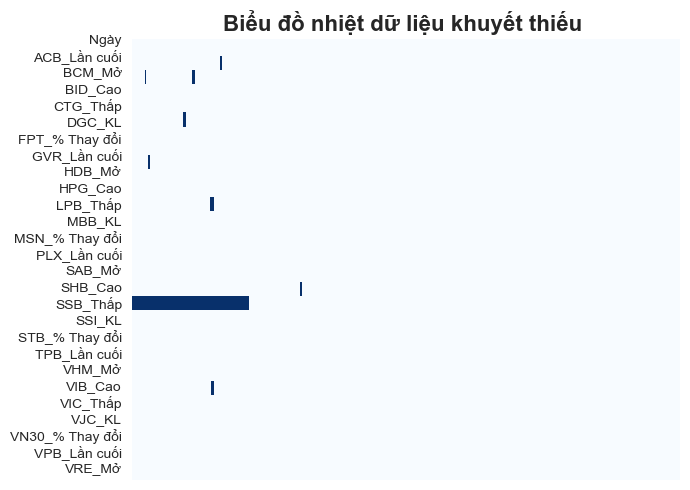

In [9]:
plt.figure(figsize=(7,5)) 
sns.heatmap(final_df.isnull().T, cbar=False, cmap='Blues') 
plt.title('Biểu đồ nhiệt dữ liệu khuyết thiếu ', fontsize=16, fontweight ="bold")
plt.xticks([])  
plt.tight_layout() 
plt.savefig('./images/missing_value_heatmap_no_clean.png')
plt.show()

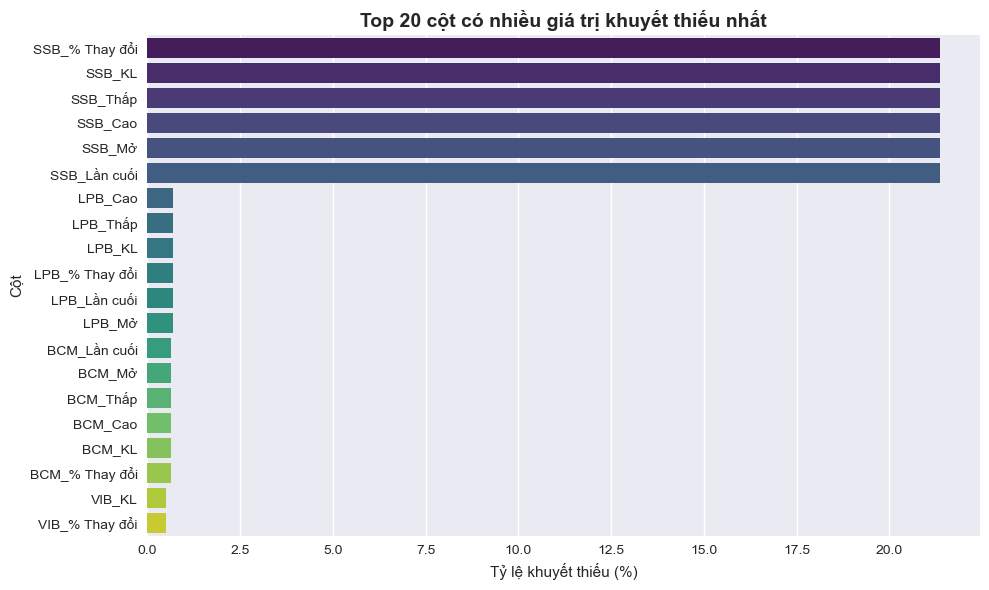

In [10]:
plt.figure(figsize=(10, 6))
top_20 = missing_df.head(20)
sns.barplot(data=top_20, x='Tỷ lệ (%)', y='Cột', palette='viridis')
plt.title('Top 20 cột có nhiều giá trị khuyết thiếu nhất', fontsize=14, fontweight='bold')
plt.xlabel('Tỷ lệ khuyết thiếu (%)')
plt.tight_layout()
plt.savefig('./images/missing_values_top20.png')
plt.show()

In [11]:
df_cleaned = final_df.copy()
df_cleaned = df_cleaned.sort_values('Ngày').reset_index(drop=True)

In [12]:
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].interpolate(method='linear', limit_direction='both')

In [13]:
#forward and backward fill
df_cleaned = df_cleaned.fillna(method='ffill')
df_cleaned = df_cleaned.fillna(method='bfill')
#drop nếu còn (rất hiếm)
rows_before = len(df_cleaned)
df_cleaned = df_cleaned.dropna()
rows_after = len(df_cleaned)

In [14]:
print(f"\nSố dòng trước: {rows_before:,}")
print(f"Số dòng sau: {rows_after:,}")
print(f"Đã loại bỏ: {rows_before - rows_after:,} dòng")


Số dòng trước: 1,427
Số dòng sau: 1,427
Đã loại bỏ: 0 dòng


In [15]:
missing_after = df_cleaned.isnull().sum().sum()
print(f"\nTổng missing sau xử lý: {missing_after:,}")

if missing_after == 0:
    print("Đã xử lý hết missing values!")
else:
    print(f"Còn {missing_after:,} missing values")


Tổng missing sau xử lý: 0
Đã xử lý hết missing values!


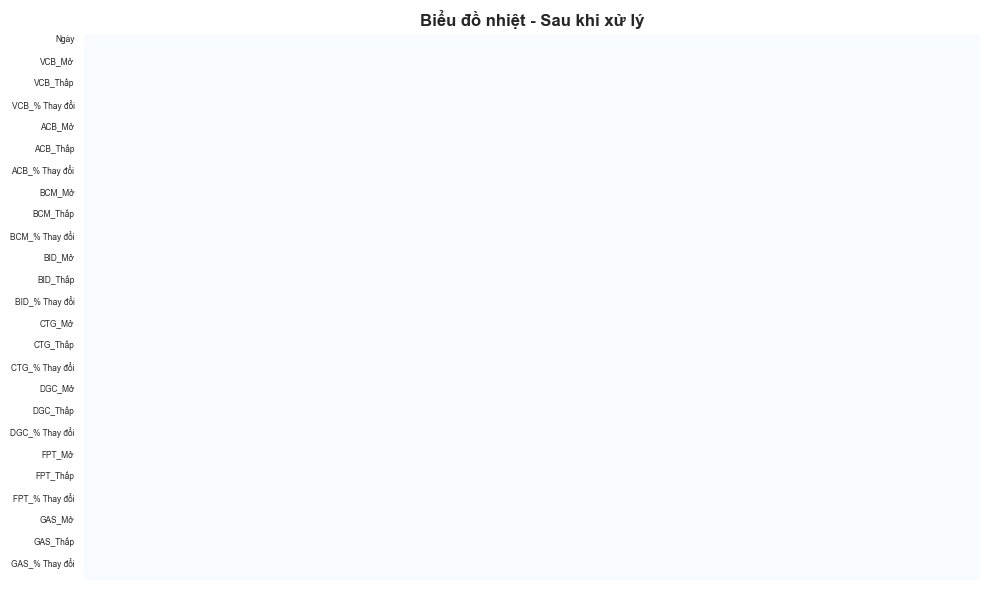


Shape cuối: (1427, 187)


In [16]:
plt.figure(figsize=(10, 6))
sample_cols = df_cleaned.columns[:50]
sns.heatmap(df_cleaned[sample_cols].isnull().T, cbar=False, cmap='Blues')
plt.title('Biểu đồ nhiệt - Sau khi xử lý', fontsize=12, fontweight='bold')
plt.xticks([])
plt.yticks(fontsize=6)
plt.tight_layout()
plt.savefig('./images/missing_values_heatmap_after_cleaned.png')
plt.show()

print(f"\nShape cuối: {df_cleaned.shape}")

In [17]:
df_cleaned.to_csv('data_processed/data.csv', index=False)

## 4. Phân tích tương quan giữa biến mục tiêu với các biến nhằm loại bỏ biến nhiễu


### 4.0. Trực quan hóa dữ liệu biến mục tiêu VCB_ Lần cuối theo thời gian

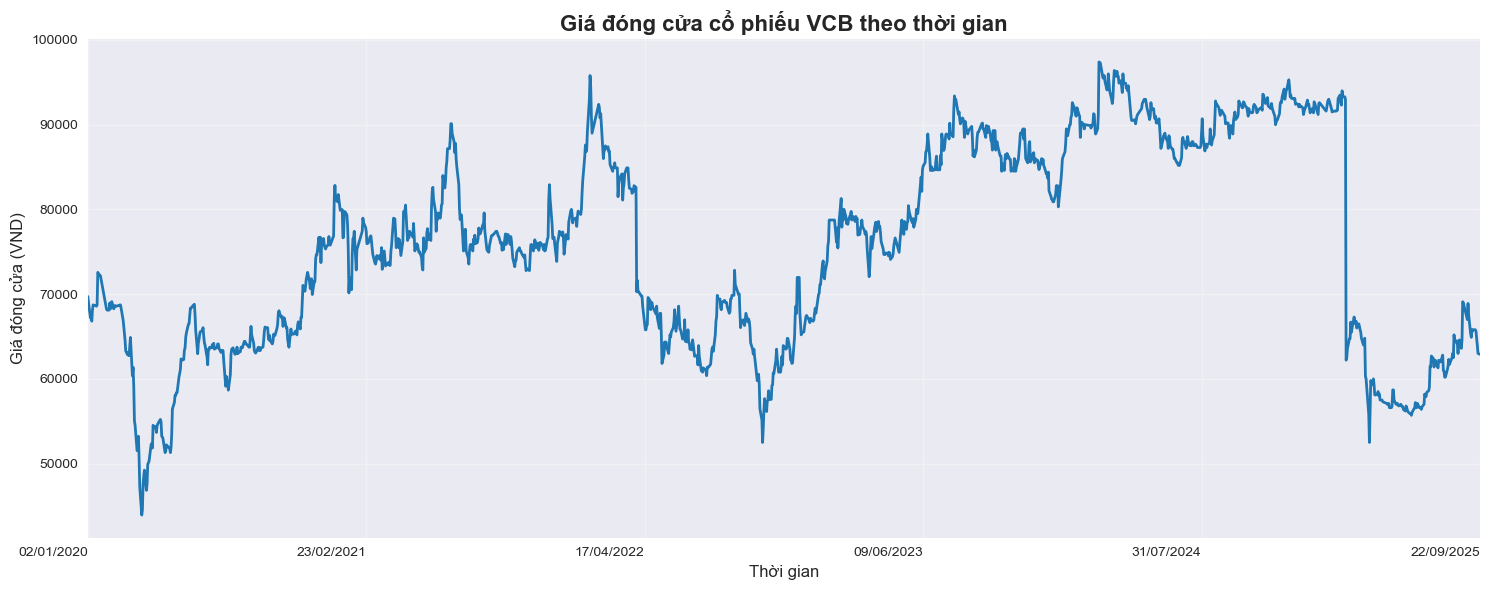

In [18]:
plt.figure(figsize=(15, 6))
plt.plot(df_cleaned['Ngày'], df_cleaned['VCB_Lần cuối'], linewidth=2)

ax = plt.gca()

start_date = df_cleaned['Ngày'].min()
end_date = df_cleaned['Ngày'].max()
ax.set_xlim(start_date, end_date)

tick_dates = pd.date_range(start=start_date, end=end_date, periods=6) 
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.title('Giá đóng cửa cổ phiếu VCB theo thời gian', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá đóng cửa (VND)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./images/VCB_Lần_cuối_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.1. Phân tích tương quan và loại bỏ biến nhiễu

In [19]:
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
correlation_matrix = df_cleaned[numeric_cols].corr()
target_corr = correlation_matrix['VCB_Lần cuối'].sort_values(ascending=False)

print("Top 20 biến có tương quan cao")
for i, (var, corr) in enumerate(target_corr.head(21)[1:].items(), 1):
    print(f"{i:2d}. {var:30s}: {corr:.4f}")

# Xác định biến nhiễu (|correlation| < 0.1)
noise_threshold = 0.1
noise_vars = [var for var in target_corr.index 
              if abs(target_corr[var]) < noise_threshold and var != 'VCB_Lần cuối']

print("Các biến nhiễu với r<0.1")
print(f"Số lượng: {len(noise_vars)} biến")
for i, var in enumerate(noise_vars[:10], 1):  # Hiển thị 10 biến đầu
    print(f"{i:2d}. {var:30s}: {target_corr[var]:.4f}")
if len(noise_vars) > 10:
    print(f"... và {len(noise_vars)-10} biến khác")

# Loại bỏ biến nhiễu
df_cleaned_no_noise = df_cleaned.drop(columns=noise_vars)
print(f"\nĐã loại bỏ {len(noise_vars)} biến nhiễu")
print(f"Số cột còn lại: {len(df_cleaned_no_noise.columns)}")

Top 20 biến có tương quan cao
 1. VCB_Cao                       : 0.9980
 2. VCB_Thấp                      : 0.9972
 3. VCB_Mở                        : 0.9956
 4. BID_Thấp                      : 0.5613
 5. BID_Mở                        : 0.5525
 6. BID_Lần cuối                  : 0.5522
 7. BID_Cao                       : 0.5430
 8. ACB_Thấp                      : 0.5344
 9. ACB_Lần cuối                  : 0.5297
10. ACB_Mở                        : 0.5261
11. ACB_Cao                       : 0.5217
12. VIB_Thấp                      : 0.4889
13. VIB_Lần cuối                  : 0.4823
14. VIB_Mở                        : 0.4795
15. VIB_Cao                       : 0.4753
16. HPG_Thấp                      : 0.4694
17. HPG_Lần cuối                  : 0.4672
18. HPG_Mở                        : 0.4660
19. HPG_Cao                       : 0.4621
20. GVR_Thấp                      : 0.4621
Các biến nhiễu với r<0.1
Số lượng: 55 biến
 1. SHB_Mở                        : 0.0995
 2. SHB_Lần cuối        

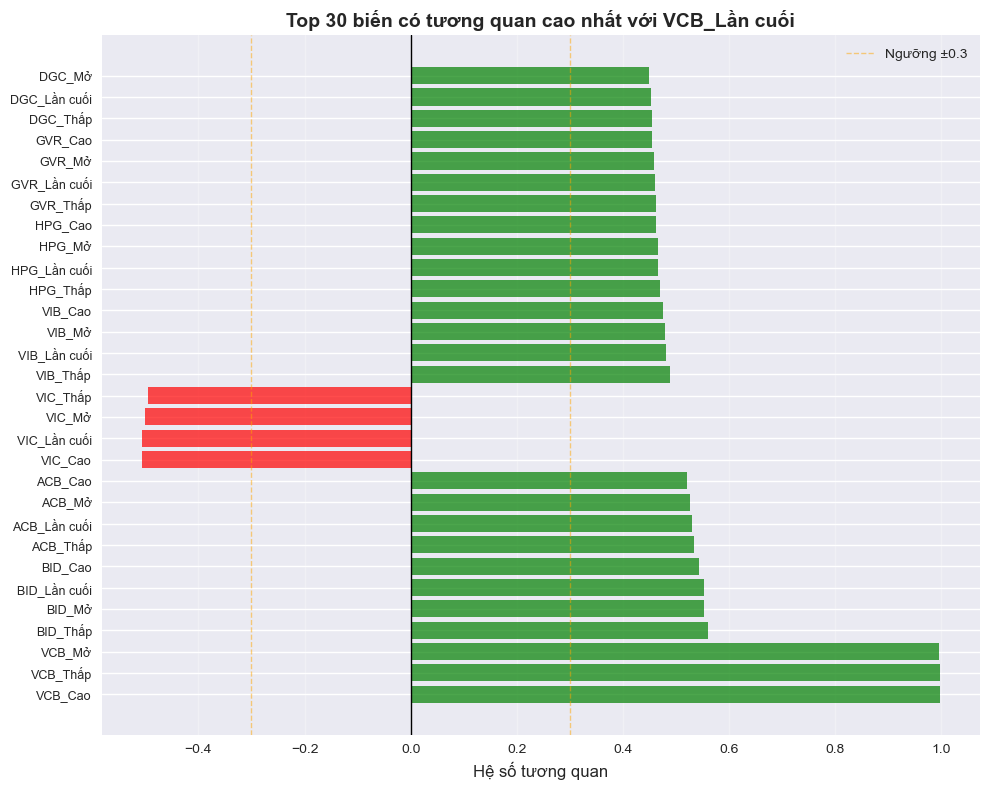

In [20]:
# Biểu đồ 1: Top 30 biến có tương quan cao nhất
plt.figure(figsize=(10, 8))
top_30 = target_corr.abs().sort_values(ascending=False).head(31)[1:]
colors = ['green' if target_corr[var] > 0 else 'red' for var in top_30.index]
plt.barh(range(len(top_30)), [target_corr[var] for var in top_30.index], color=colors, alpha=0.7)
plt.yticks(range(len(top_30)), top_30.index, fontsize=9)
plt.xlabel('Hệ số tương quan', fontsize=12)
plt.title('Top 30 biến có tương quan cao nhất với VCB_Lần cuối', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.axvline(x=0.3, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Ngưỡng ±0.3')
plt.axvline(x=-0.3, color='orange', linestyle='--', linewidth=1, alpha=0.5)
plt.grid(True, alpha=0.3, axis='x')
plt.legend()
plt.tight_layout()
plt.savefig('./images/top_30_bien_tuong_quan_cao.png', dpi=300, bbox_inches='tight')
plt.show()

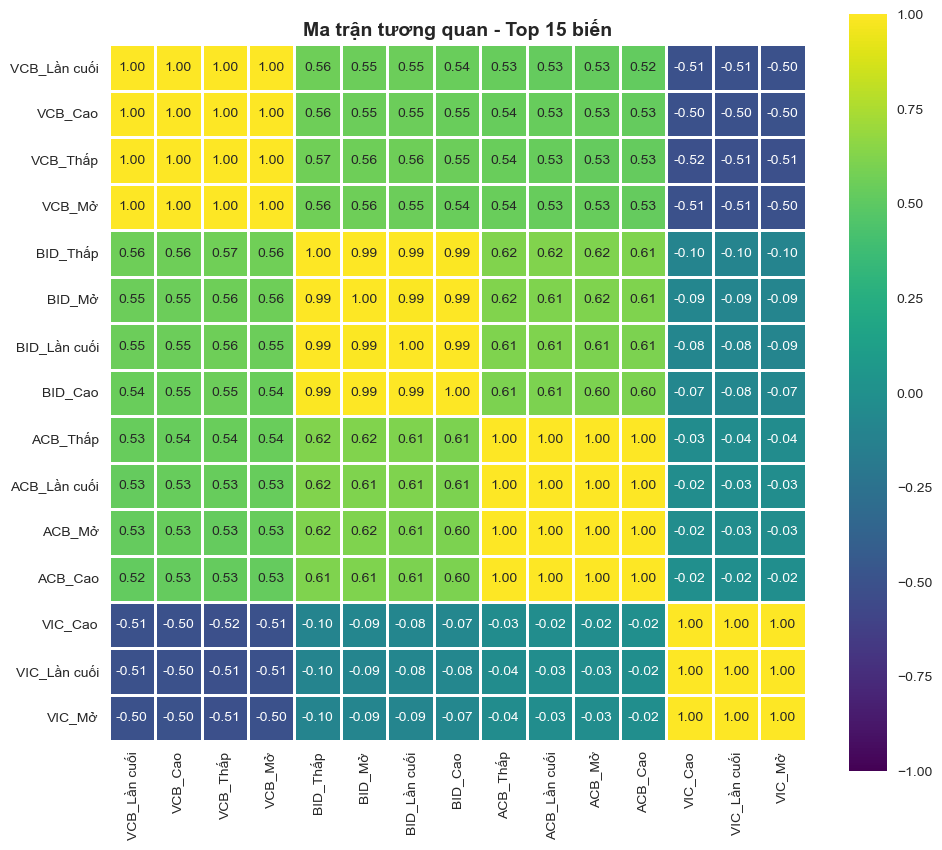

In [21]:
# Heatmap top 15 biến
top_15_vars = ['VCB_Lần cuối'] + target_corr.abs().sort_values(ascending=False).head(16)[1:15].index.tolist()
corr_matrix_top15 = df_cleaned[top_15_vars].corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix_top15, annot=True, fmt='.2f', cmap='viridis', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1)
plt.title('Ma trận tương quan - Top 15 biến', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('./images/heat map tương quan biến mục tiêu VCB_ Lần cuối theo thời gian.png')
plt.show()

## 5. Phân cụm bằng K-mean và giảm chiều bằng phương pháp PCA, trực quan hoá (2đ) 

### 5.1. Giảm chiều dữ liệu bằng PCA, tiền xử lý trước Kmean clustering

In [22]:
X = df_cleaned_no_noise.select_dtypes(include=[np.number]).values

In [23]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Đã chuẩn hóa dữ liệu")

Đã chuẩn hóa dữ liệu


In [24]:
print(f"Số mẫu: {X_scaled.shape[0]:,}")
print(f"Số features: {X_scaled.shape[1]:,}")

Số mẫu: 1,427
Số features: 131


In [25]:
pca_full = PCA()
pca_full.fit(X_scaled)

PCA()

In [26]:
# Lấy explained variance
var_ratio = pca_full.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

In [27]:
VAR_THRESHOLD = 0.70
n_components = (cum_var >= VAR_THRESHOLD).argmax() + 1

print(f"Ngưỡng phương sai: {VAR_THRESHOLD*100:.0f}%")
print(f"components được chọn: {n_components}")
print(f"Phương sai tích lũy: {cum_var[n_components-1]*100:.2f}%")

# Hiển thị phương sai của từng PC
print(f" Phương sai củacủa {min(10, len(var_ratio))} thành phần đầu tiên")
for i in range(min(10, len(var_ratio))):
    print(f"PC{i+1}: {var_ratio[i]*100:6.2f}% | Tích lũy: {cum_var[i]*100:6.2f}%")

Ngưỡng phương sai: 70%
components được chọn: 3
Phương sai tích lũy: 75.57%
 Phương sai củacủa 10 thành phần đầu tiên
PC1:  47.72% | Tích lũy:  47.72%
PC2:  17.89% | Tích lũy:  65.61%
PC3:   9.96% | Tích lũy:  75.57%
PC4:   5.54% | Tích lũy:  81.11%
PC5:   2.87% | Tích lũy:  83.98%
PC6:   2.29% | Tích lũy:  86.27%
PC7:   1.82% | Tích lũy:  88.09%
PC8:   1.28% | Tích lũy:  89.37%
PC9:   1.06% | Tích lũy:  90.43%
PC10:   0.97% | Tích lũy:  91.40%


In [28]:
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Tạo DataFrame với các PC
pc_cols = [f'PC{i+1}' for i in range(n_components)]
pca_df = pd.DataFrame(X_pca, columns=pc_cols)
pca_df.head()

,PC1,PC2,PC3
0,-14.329042,3.137915,-1.688319
1,-14.173765,3.284418,-1.836011
2,-14.372289,3.129525,-1.564288
3,-14.486586,3.071551,-1.544773
4,-14.445101,2.854599,-1.857576


In [29]:
df_with_pca = pd.concat([
    df_cleaned_no_noise[['Ngày', 'VCB_Lần cuối']].reset_index(drop=True), 
    pca_df
], axis=1)

display(df_with_pca.head())

# Lưu file
df_with_pca.to_excel('./data_processed/KQ_PCA.xlsx', index=False)
df_with_pca.to_csv('./data_processed/KQ_PCA.csv', index=False)
print(f"Đã lưu: KQ_PCA.xlsx và KQ_PCA.csv")

,Ngày,VCB_Lần cuối,PC1,PC2,PC3
0,2020-01-02,69728.0,-14.329042,3.137915,-1.688319
1,2020-01-03,69037.0,-14.173765,3.284418,-1.836011
2,2020-01-06,67194.0,-14.372289,3.129525,-1.564288
3,2020-01-07,67424.0,-14.486586,3.071551,-1.544773
4,2020-01-08,66810.0,-14.445101,2.854599,-1.857576


Đã lưu: KQ_PCA.xlsx và KQ_PCA.csv


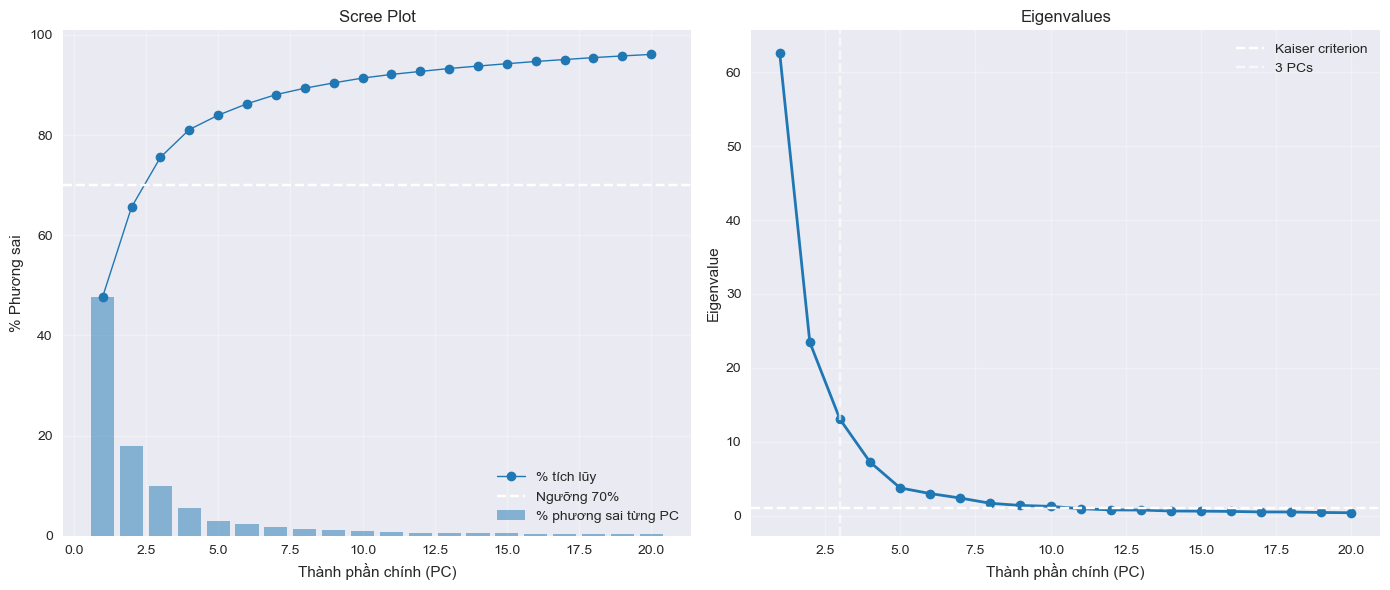

In [30]:
# Vẽ Scree Plot 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

n_show = min(20, len(var_ratio))
axes[0].bar(range(1, n_show+1), var_ratio[:n_show]*100, alpha=0.5, label='% phương sai từng PC')
axes[0].plot(range(1, n_show+1), cum_var[:n_show]*100, 'o-', linewidth=1, label='% tích lũy')
axes[0].axhline(y=VAR_THRESHOLD*100, linestyle='--', label=f'Ngưỡng {VAR_THRESHOLD*100:.0f}%')
axes[0].set_xlabel('Thành phần chính (PC)')
axes[0].set_ylabel('% Phương sai')
axes[0].set_title('Scree Plot')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Eigenvalues
eigenvalues = pca_full.explained_variance_
n_eigen = min(20, len(eigenvalues))
axes[1].plot(range(1, n_eigen+1), eigenvalues[:n_eigen], 'o-', linewidth=2)
axes[1].axhline(y=1, linestyle='--', label='Kaiser criterion')
axes[1].axvline(x=n_components, linestyle='--', alpha=0.7, label=f'{n_components} PCs')
axes[1].set_xlabel('Thành phần chính (PC)') 
axes[1].set_ylabel('Eigenvalue')
axes[1].set_title('Eigenvalues')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./images/scree_plot_pca.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.2. Gom cụm dữ liệu bằng Kmean clustering

In [31]:
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    print(f"K={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores[-1]:.4f}")

# Chọn K tối ưu
optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nSố cụm tối ưu: K = {optimal_k} (Silhouette Score = {max(silhouette_scores):.4f})")

K=2: Inertia=124532.91, Silhouette=0.2967
K=3: Inertia=94708.95, Silhouette=0.3437
K=4: Inertia=71572.39, Silhouette=0.3644
K=5: Inertia=58890.32, Silhouette=0.3919
K=6: Inertia=50579.40, Silhouette=0.3951
K=7: Inertia=45499.46, Silhouette=0.3919
K=8: Inertia=41449.95, Silhouette=0.3614
K=9: Inertia=38257.37, Silhouette=0.3631
K=10: Inertia=35197.16, Silhouette=0.3512

Số cụm tối ưu: K = 6 (Silhouette Score = 0.3951)


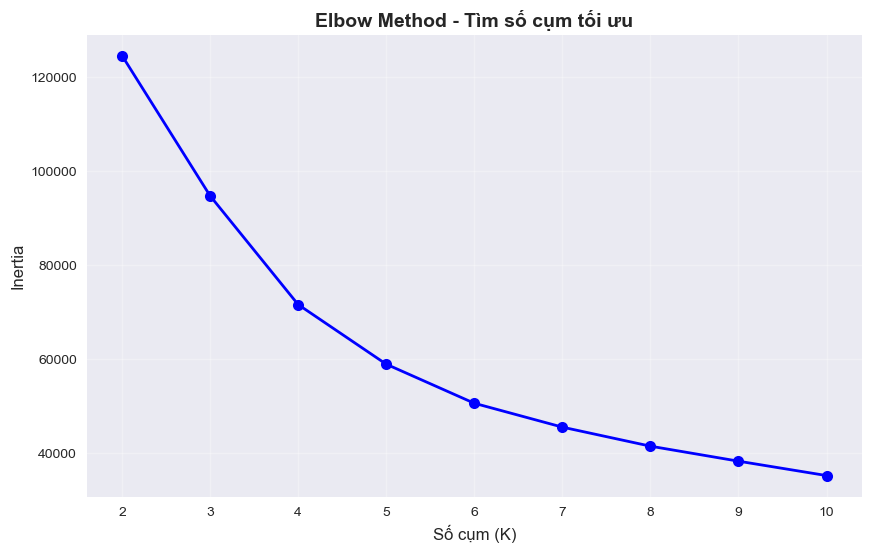

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Số cụm (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method - Tìm số cụm tối ưu', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.savefig('./images/elbow_plot', dpi=300, bbox_inches='tight')
plt.show()

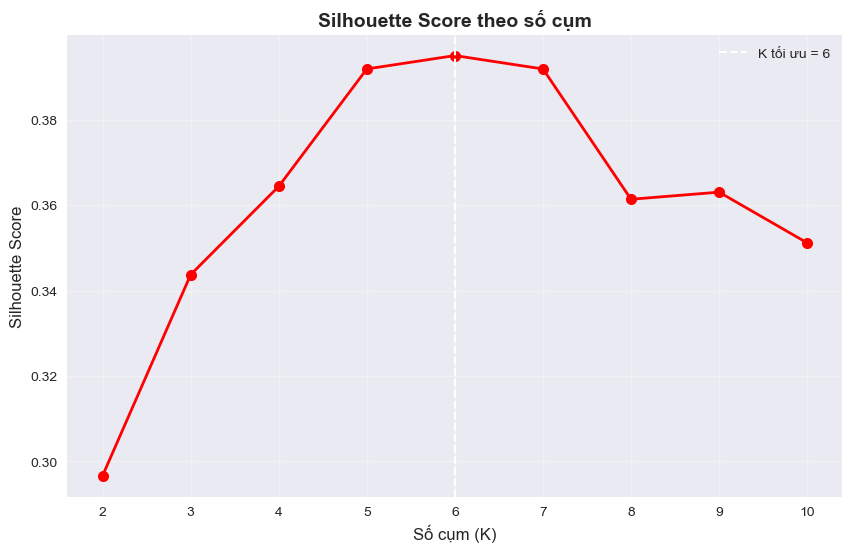

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, linestyle='--', linewidth=1.5, label=f'K tối ưu = {optimal_k}')
plt.xlabel('Số cụm (K)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score theo số cụm', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.savefig('images/silhoulette_score_plot', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

In [35]:
print("Thống kê các cụm")
for i in range(optimal_k):
    count = np.sum(clusters == i)
    percentage = count / len(clusters) * 100
    print(f"Cụm {i}: {count:,} mẫu ({percentage:.1f}%)")

silhouette_avg = silhouette_score(X_scaled, clusters)
print(f"\n✓ Silhouette Score: {silhouette_avg:.4f}")

Thống kê các cụm
Cụm 0: 427 mẫu (29.9%)
Cụm 1: 234 mẫu (16.4%)
Cụm 2: 369 mẫu (25.9%)
Cụm 3: 228 mẫu (16.0%)
Cụm 4: 55 mẫu (3.9%)
Cụm 5: 114 mẫu (8.0%)

✓ Silhouette Score: 0.3951


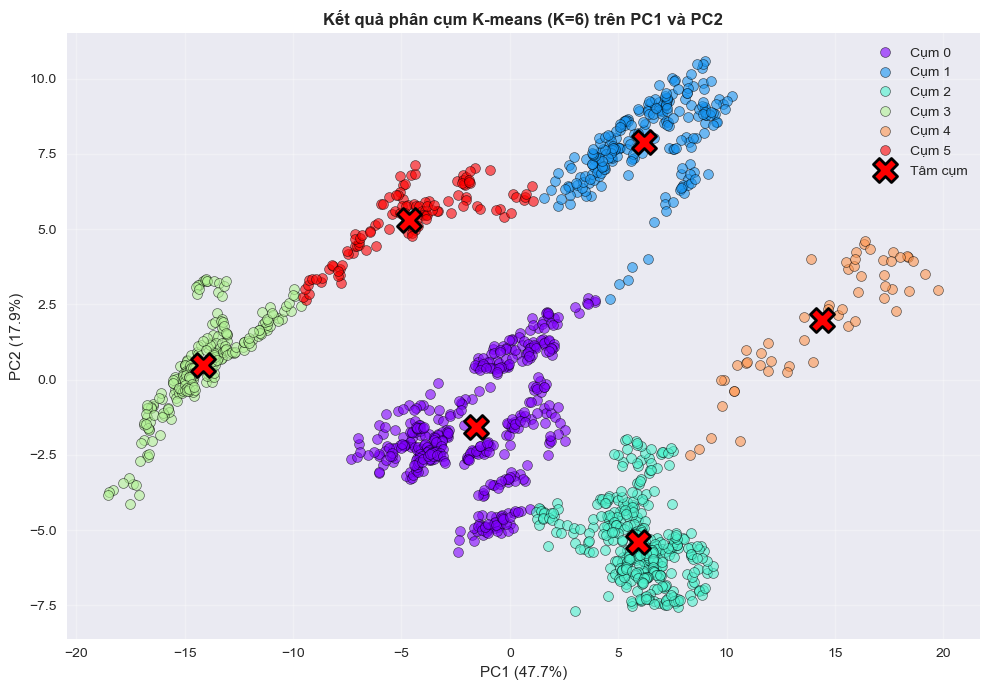

In [36]:
fig, ax = plt.subplots(figsize=(10, 7))

colors = plt.cm.rainbow(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_points = X_pca[clusters == i]
    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               c=[colors[i]], label=f'Cụm {i}', s=50, alpha=0.6, 
               edgecolors='black', linewidth=0.5)

# Tính tâm cụm trực tiếp từ dữ liệu PCA
centers_pca = np.array([X_pca[clusters == i].mean(axis=0) for i in range(optimal_k)])

# Vẽ tâm cụm
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='red', marker='X', s=300, edgecolors='black', linewidth=2, 
           label='Tâm cụm', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'Kết quả phân cụm K-means (K={optimal_k}) trên PC1 và PC2', fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./images/kmeans_clustering_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
print("Phân tích các cụm")
df_with_pca['Cluster'] = clusters
#phân tích giá vcb theo cụmcụm
cluster_analysis = df_with_pca.groupby('Cluster')['VCB_Lần cuối'].agg([
    ('Số mẫu', 'count'),
    ('Trung bình', 'mean'),
    ('Trung vị', 'median'),
    ('Min', 'min'),
    ('Max', 'max'),
    ('Độ lệch chuẩn', 'std')
]).round(2)

display(cluster_analysis)

Phân tích các cụm


,Số mẫu,Trung bình,Trung vị,Min,Max,Độ lệch chuẩn
Cluster,,,,,,
0,427,75405.99,76799.0,52498.0,93400.0,10150.66
1,234,79108.24,77342.0,65792.0,95800.0,5536.98
2,369,84006.39,90700.0,52500.0,97400.0,13644.48
3,228,62906.11,64122.0,43925.0,72569.0,5892.85
4,55,63343.64,62800.0,57900.0,69100.0,2543.38
5,114,75909.43,75793.0,69958.0,82838.0,2620.94


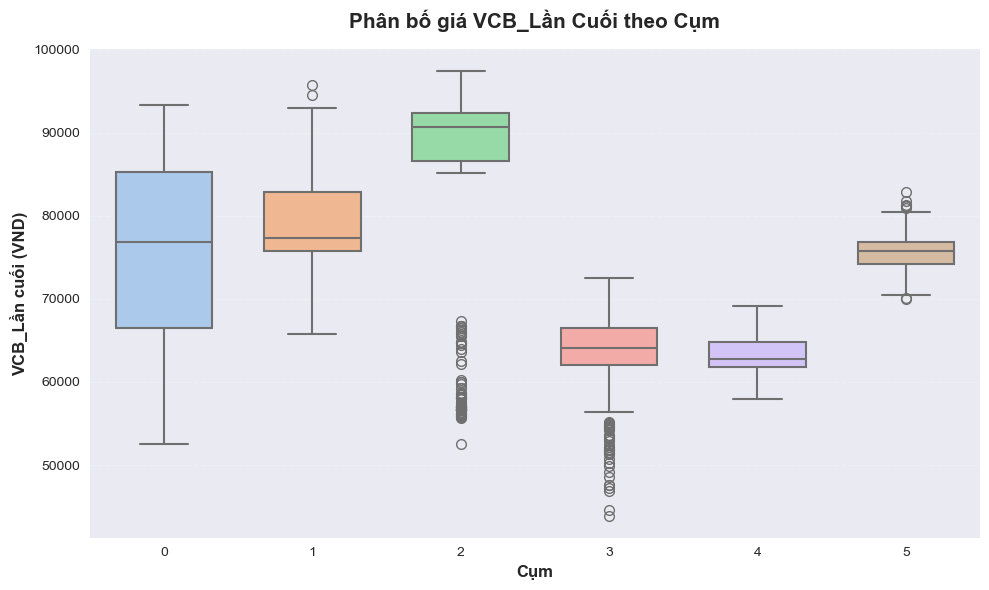

In [38]:
plt.figure(figsize=(10, 6))

# Create boxplot with subtle colors
sns.boxplot(
    data=df_with_pca,
    x='Cluster',
    y='VCB_Lần cuối',
    palette='pastel',
    linewidth=1.5,
    width=0.65
)

# Styling
plt.title("Phân bố giá VCB_Lần Cuối theo Cụm", fontsize=15, weight='bold', pad=15)
plt.xlabel("Cụm", fontsize=12, weight='bold')
plt.ylabel("VCB_Lần cuối (VND)", fontsize=12, weight='bold')
plt.grid(True, alpha=0.2, axis='y', linestyle='--')

sns.despine()      
plt.tight_layout()
plt.savefig('./images/boxplot_theo_cụm.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
df_with_pca.to_excel('./data_processed/KQ_PCA_Kmeans.xlsx', index=False)
df_with_pca.to_csv('./data_processed/KQ_PCA_Kmeans.csv', index=False)

print(f"Đã lưu: KQ_PCA_Kmeans.xlsx và KQ_PCA_Kmeans.csv")
print(f"Shape: {df_with_pca.shape}")
print(f"Các cột: {df_with_pca.columns.tolist()}")

Đã lưu: KQ_PCA_Kmeans.xlsx và KQ_PCA_Kmeans.csv
Shape: (1427, 6)
Các cột: ['Ngày', 'VCB_Lần cuối', 'PC1', 'PC2', 'PC3', 'Cluster']


## 6. Huấn luyện mô hình dự đoán biến mục tiêu theo các thành phần chính được chọn  bằng mô hình học máy và trực quan hoá kết quả

In [40]:
df_pca = pd.read_excel('./data_processed/KQ_PCA.xlsx')
df_pca.head()

,Ngày,VCB_Lần cuối,PC1,PC2,PC3
0,2020-01-02,69728,-14.329042,3.137915,-1.688319
1,2020-01-03,69037,-14.173765,3.284418,-1.836011
2,2020-01-06,67194,-14.372289,3.129525,-1.564288
3,2020-01-07,67424,-14.486586,3.071551,-1.544773
4,2020-01-08,66810,-14.445101,2.854599,-1.857576


In [41]:
feature_cols = [col for col in df_pca.columns if col.startswith('PC') or col == "Cluster"]

X = df_pca[feature_cols]
y = df_pca[target_column]

print(f"Các cột được chọn làm features: {X.columns.tolist()}")

Các cột được chọn làm features: ['PC1', 'PC2', 'PC3']


In [42]:
print(f"\nFeatures (X): {feature_cols}")
print(f"Target (y): VCB_Lần cuối")
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")


Features (X): ['PC1', 'PC2', 'PC3']
Target (y): VCB_Lần cuối
Shape X: (1427, 3)
Shape y: (1427,)


In [43]:
split_ratio = 0.8
split_idx = int(len(df_pca) * split_ratio)

train_data = df_pca.iloc[:split_idx]
test_data = df_pca.iloc[split_idx:]

# Features và target
X_train_lr = train_data[feature_cols]
y_train_lr = train_data[target_column]

X_test_lr = test_data[feature_cols]
y_test_lr = test_data[target_column]

print(f"  Train: {X_train_lr.shape} ({len(train_data)/len(df_pca)*100:.1f}%)")
print(f"  Test:  {X_test_lr.shape} ({len(test_data)/len(df_pca)*100:.1f}%)")

  Train: (1141, 3) (80.0%)
  Test:  (286, 3) (20.0%)


### 6.1. Mô hình SARIMAX

In [44]:
def check_stationarity(series, name='Series'):
    """Kiểm tra tính dừng bằng ADF test"""
    result = adfuller(series.dropna())
    print(f'\n{name}:')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\033[32mChuỗi Dừng\033[0m")
        return True
    else:
        print("\033[31mChuỗi Không Dừng\033[0m")
        return False

In [45]:
is_stationary = check_stationarity(df_pca[target_column], 'VCB_Lần cuối (Original)')

vcb_diff = df_pca[target_column].diff().dropna()
is_stationary_diff = check_stationarity(vcb_diff, 'VCB_Lần cuối (After diff)')


VCB_Lần cuối (Original):
ADF Statistic: -2.221366
p-value: 0.198582
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Chuỗi Không Dừng

VCB_Lần cuối (After diff):
ADF Statistic: -23.110430
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Chuỗi Dừng


In [46]:
for i in range(3):
    pc_col = feature_cols[i]
    pc_diff = df_pca[pc_col].diff().dropna()
    check_stationarity(pc_diff, f'{pc_col} (After diff)')


PC1 (After diff):
ADF Statistic: -14.835236
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Chuỗi Dừng

PC2 (After diff):
ADF Statistic: -35.229974
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Chuỗi Dừng

PC3 (After diff):
ADF Statistic: -23.420612
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
Chuỗi Dừng


In [47]:
split_ratio = 0.8
split_idx = int(len(df_pca) * split_ratio)

train_original = df_pca.iloc[:split_idx].copy()
test_original = df_pca.iloc[split_idx:].copy()

print(f"Chia tách dữ liệu gốc cho mô hình Sarimax:")
print(f"  Train original: {train_original.shape}")
print(f"  Test original:  {test_original.shape}")

Chia tách dữ liệu gốc cho mô hình Sarimax:
  Train original: (1141, 5)
  Test original:  (286, 5)


In [48]:
# Diff riêng cho train
train_diff = train_original.copy()
train_diff[target_column] = train_original[target_column].diff()
for col in feature_cols:
    train_diff[col] = train_original[col].diff()
train_diff = train_diff.dropna()

# Diff riêng cho test
test_diff = test_original.copy()
test_diff[target_column] = test_original[target_column].diff()
for col in feature_cols:
    test_diff[col] = test_original[col].diff()
test_diff = test_diff.dropna()

print(f"\nChia tách dữ liệu sau khi sai phân:")
print(f"  Train diff: {train_diff.shape}")
print(f"  Test diff:  {test_diff.shape}")


Chia tách dữ liệu sau khi sai phân:
  Train diff: (1140, 5)
  Test diff:  (285, 5)


In [49]:
y_train_sarimax = train_diff[target_column]
X_train_sarimax = train_diff[feature_cols]

y_test_sarimax = test_diff[target_column]
X_test_sarimax = test_diff[feature_cols]

print(f"\n Đã chuẩn bị dữ liệu cho mô hình SARIMAX:")
print(f"  y_train: {y_train_sarimax.shape}")
print(f"  X_train: {X_train_sarimax.shape}")
print(f"  y_test:  {y_test_sarimax.shape}")
print(f"  X_test:  {X_test_sarimax.shape}")


 Đã chuẩn bị dữ liệu cho mô hình SARIMAX:
  y_train: (1140,)
  X_train: (1140, 3)
  y_test:  (285,)
  X_test:  (285, 3)


In [50]:
# SARIMAX parameters (d=0 vì đã diff trước)
order = (1, 0, 1)
seasonal_order = (0, 0, 0, 0)

print(f"SARIMAX order: {order}, seasonal: {seasonal_order}")

start_time = time.time()

model_sarimax = SARIMAX(
    endog=y_train_sarimax,
    exog=X_train_sarimax,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_sarimax = model_sarimax.fit(disp=False, maxiter=200)

training_time = time.time() - start_time

print(f"\nSARIMAX huấn luyện trong {training_time:.2f}s")
print(f"  AIC: {results_sarimax.aic:.2f}")
print(f"  BIC: {results_sarimax.bic:.2f}")

SARIMAX order: (1, 0, 1), seasonal: (0, 0, 0, 0)

SARIMAX huấn luyện trong 0.41s
  AIC: 19314.23
  BIC: 19344.45


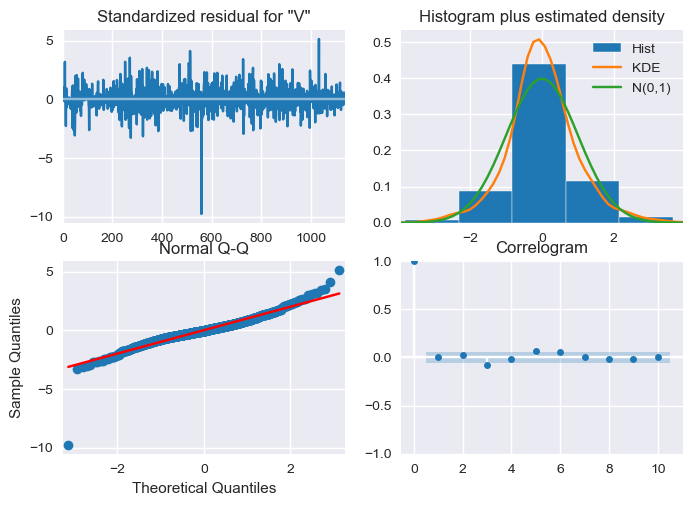

In [51]:
results_sarimax.plot_diagnostics();

In [52]:
y_pred_diff = results_sarimax.forecast(steps=len(y_test_sarimax), exog=X_test_sarimax)

# Metrics on differenced data
mae_diff = mean_absolute_error(y_test_sarimax, y_pred_diff)
rmse_diff = np.sqrt(mean_squared_error(y_test_sarimax, y_pred_diff))
r2_diff = r2_score(y_test_sarimax, y_pred_diff)

print("\nĐánh giá mô hình SARIMAX đã sai phân bậc 1:")
print(f"{'Metric':<10} {'Value':<12}")
print(f"{'MAE':<10} {mae_diff:<12.4f}")
print(f"{'RMSE':<10} {rmse_diff:<12.4f}")
print(f"{'R²':<10} {r2_diff:<12.4f}")


Đánh giá mô hình SARIMAX đã sai phân bậc 1:
Metric     Value       
MAE        703.9146    
RMSE       1980.5200   
R²         0.0636      


In [53]:
# Lấy giá trị cuối từ train original làm anchor
last_train_value = train_original[target_column].iloc[-1]

# Test original values (align với test_diff)
y_test_original = test_original[target_column].iloc[1:1+len(y_pred_diff)].values

# Inverse predictions (cumsum)
# Inverse predictions (cumsum)
y_pred_original_sarimax = np.zeros(len(y_pred_diff))
y_pred_original_sarimax[0] = last_train_value + y_pred_diff.iloc[0]
for i in range(1, len(y_pred_diff)):
    y_pred_original_sarimax[i] = y_pred_original_sarimax[i-1] + y_pred_diff.iloc[i]

# Metrics on original scale
mae_original_sarimax = mean_absolute_error(y_test_original, y_pred_original_sarimax)
rmse_original_sarimax = np.sqrt(mean_squared_error(y_test_original, y_pred_original_sarimax))
mape_original_sarimax = np.mean(np.abs((y_test_original - y_pred_original_sarimax) / y_test_original)) * 100
r2_original_sarimax = r2_score(y_test_original, y_pred_original_sarimax)

print("\nĐánh giá mô hình SARIMAX khi chuyển về thang đo gốc:")
print(f"{'Metric':<10} {'Value':<12}")
print(f"{'MAE':<10} {mae_original_sarimax:<12.2f}")
print(f"{'RMSE':<10} {rmse_original_sarimax:<12.2f}")
print(f"{'MAPE':<10} {mape_original_sarimax:<12.2f}%")
print(f"{'R²':<10} {r2_original_sarimax:<12.4f}")


Đánh giá mô hình SARIMAX khi chuyển về thang đo gốc:
Metric     Value       
MAE        16318.17    
RMSE       20911.54    
MAPE       25.76       %
R²         -0.7845     


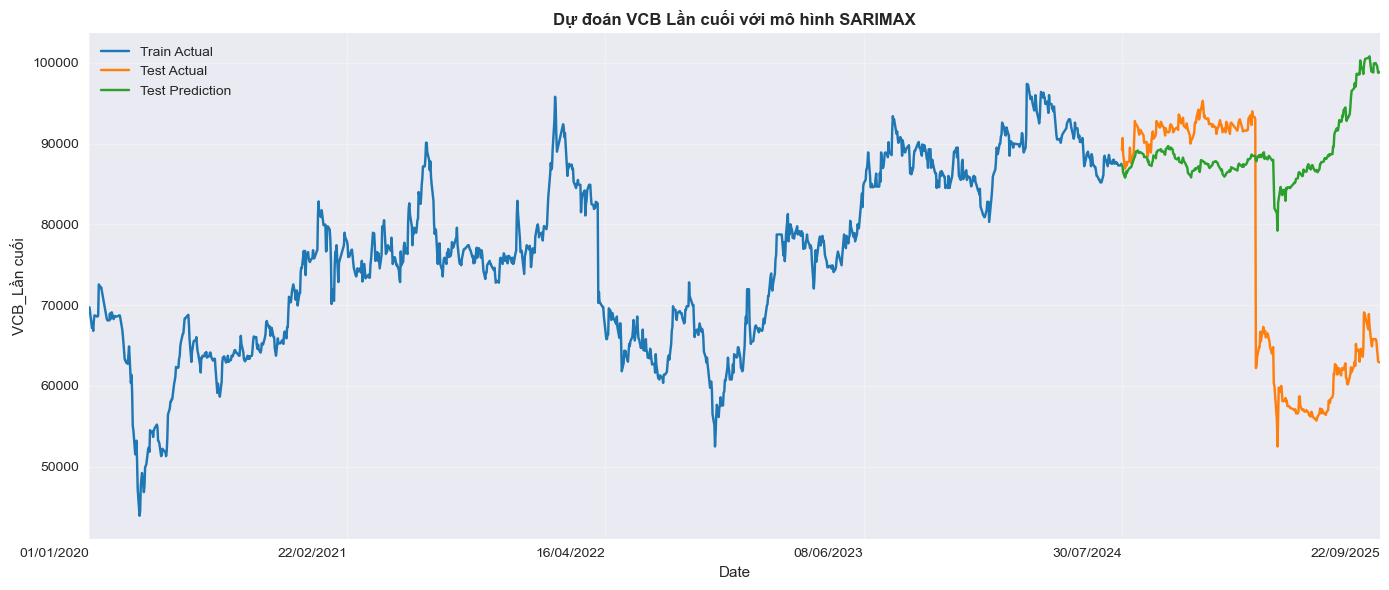

In [54]:

n_train = len(train_original)  

train_start_idx = 0  
train_end_idx = n_train + 1 

test_start_idx = train_end_idx
test_end_idx = test_start_idx + len(y_test_original)

# Lấy dates từ df_pca gốc
train_dates = pd.to_datetime(df_pca['Ngày'].iloc[train_start_idx:train_end_idx])
test_dates = pd.to_datetime(df_pca['Ngày'].iloc[test_start_idx:test_end_idx])

# Lấy giá trị gốc (chưa diff) để plot
y_train_plot = df_pca[target_column].iloc[train_start_idx:train_end_idx]
y_test_plot = df_pca[target_column].iloc[test_start_idx:test_end_idx]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_dates, y_train_plot, label='Train Actual')
ax.plot(test_dates, y_test_plot, label='Test Actual')
ax.plot(test_dates[:len(y_pred_original_sarimax)], y_pred_original_sarimax, label='Test Prediction')

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

ax.set_xlabel('Date')
ax.set_ylabel('VCB_Lần cuối')
ax.set_title('Dự đoán VCB Lần cuối với mô hình SARIMAX', fontweight="bold")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/sarimax_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.2. Mô hình ARDL

In [55]:
split_ratio = 0.8
split_idx = int(len(df_pca) * split_ratio)

train_ardl_original = df_pca.iloc[:split_idx].copy()
test_ardl_original = df_pca.iloc[split_idx:].copy()

print(f"Chia tách dữ liệu cho mô hình ARDL:")
print(f"  Train original: {train_ardl_original.shape}")
print(f"  Test original:  {test_ardl_original.shape}")

Chia tách dữ liệu cho mô hình ARDL:
  Train original: (1141, 5)
  Test original:  (286, 5)


In [56]:
train_ardl_diff = train_ardl_original.copy()
train_ardl_diff[target_column] = train_ardl_original[target_column].diff()
for col in feature_cols:
    train_ardl_diff[col] = train_ardl_original[col].diff()
train_ardl_diff = train_ardl_diff.dropna()

# Diff riêng cho test
test_ardl_diff = test_ardl_original.copy()
test_ardl_diff[target_column] = test_ardl_original[target_column].diff()
for col in feature_cols:
    test_ardl_diff[col] = test_ardl_original[col].diff()
test_ardl_diff = test_ardl_diff.dropna()

print(f"\nChia tách dữ liệu sai phân cho mô hình ARDL:")
print(f"  Train diff: {train_ardl_diff.shape}")
print(f"  Test diff:  {test_ardl_diff.shape}")


Chia tách dữ liệu sai phân cho mô hình ARDL:
  Train diff: (1140, 5)
  Test diff:  (285, 5)


In [57]:
ardl_train = train_ardl_diff[[target_column] + feature_cols].copy()
ardl_test = test_ardl_diff[[target_column] + feature_cols].copy()

print(f"\nChuẩn bị dữ lệu cho mô hình ARDL:")
print(f"  Variables: {target_column} + {len(feature_cols)} PCs")
print(f"  Train: {ardl_train.shape}")
print(f"  Test:  {ardl_test.shape}")


Chuẩn bị dữ lệu cho mô hình ARDL:
  Variables: VCB_Lần cuối + 3 PCs
  Train: (1140, 4)
  Test:  (285, 4)


In [58]:
import time

start_time = time.time()

# ARDL model với auto lag selection
model_ardl = ARDL(
    endog=ardl_train[target_column],
    exog=ardl_train[feature_cols],
    lags=2,
    order=1,
    trend='c'
)

results_ardl = model_ardl.fit()

training_time = time.time() - start_time

print(f"\nARDL huấn luyện trong {training_time:.2f}s")
print(f"  AIC: {results_ardl.aic:.2f}")
print(f"  BIC: {results_ardl.bic:.2f}")


ARDL huấn luyện trong 0.01s
  AIC: 19304.93
  BIC: 19355.30


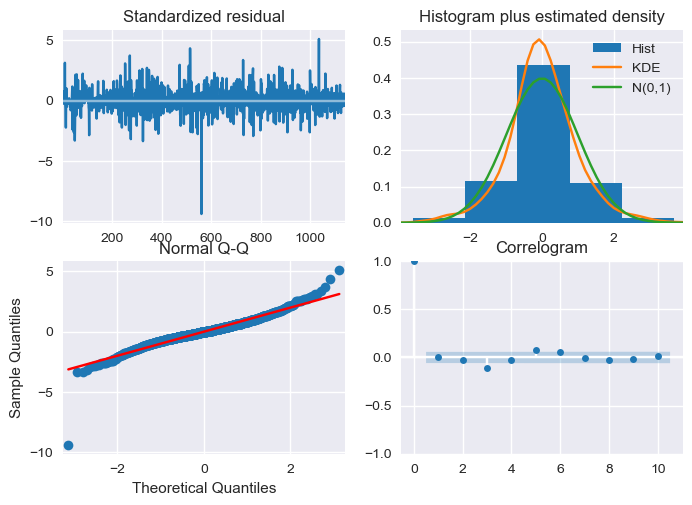

In [59]:
results_ardl.plot_diagnostics();

In [60]:
y_pred_diff = results_ardl.forecast(steps=len(ardl_test), exog=ardl_test[feature_cols])

# Align test data
y_test_diff = ardl_test[target_column].iloc[:len(y_pred_diff)]

# Metrics on differenced data
mae_diff = mean_absolute_error(y_test_diff, y_pred_diff)
rmse_diff = np.sqrt(mean_squared_error(y_test_diff, y_pred_diff))
r2_diff = r2_score(y_test_diff, y_pred_diff)

print("\nĐánh giá mô hình ARDL đã sai phân:")
print(f"\n{'Metric':<10} {'Value':<12}")
print(f"{'MAE':<10} {mae_diff:<12.4f}")
print(f"{'RMSE':<10} {rmse_diff:<12.4f}")
print(f"{'R²':<10} {r2_diff:<12.4f}")


Đánh giá mô hình ARDL đã sai phân:

Metric     Value       
MAE        749.7353    
RMSE       2011.8636   
R²         0.0338      


In [61]:
last_train_value = train_ardl_original[target_column].iloc[-1]

# Test original values (align với test_ardl_diff)
y_test_original = test_ardl_original[target_column].iloc[1:1+len(y_pred_diff)].values

# Inverse predictions (cumsum)
y_pred_original_ardl = np.zeros(len(y_pred_diff))
y_pred_original_ardl[0] = last_train_value + y_pred_diff.iloc[0]
for i in range(1, len(y_pred_diff)):
    y_pred_original_ardl[i] = y_pred_original_ardl[i-1] + y_pred_diff.iloc[i]

# Metrics on original scale
mae_original_ardl = mean_absolute_error(y_test_original, y_pred_original_ardl)
rmse_original_ardl = np.sqrt(mean_squared_error(y_test_original, y_pred_original_ardl))
mape_original_ardl = np.mean(np.abs((y_test_original - y_pred_original_ardl) / y_test_original)) * 100
r2_original_ardl = r2_score(y_test_original, y_pred_original_ardl)

print("\nĐánh giá mô hình ARDL khi chuyển về thang đo gốc:")
print(f"\n{'Metric':<10} {'Value':<12}")
print(f"{'MAE':<10} {mae_original_ardl:<12.2f}")
print(f"{'RMSE':<10} {rmse_original_ardl:<12.2f}")
print(f"{'MAPE':<10} {mape_original_ardl:<12.2f}%")
print(f"{'R²':<10} {r2_original_ardl:<12.4f}")


Đánh giá mô hình ARDL khi chuyển về thang đo gốc:

Metric     Value       
MAE        17385.91    
RMSE       22903.06    
MAPE       27.73       %
R²         -1.1405     


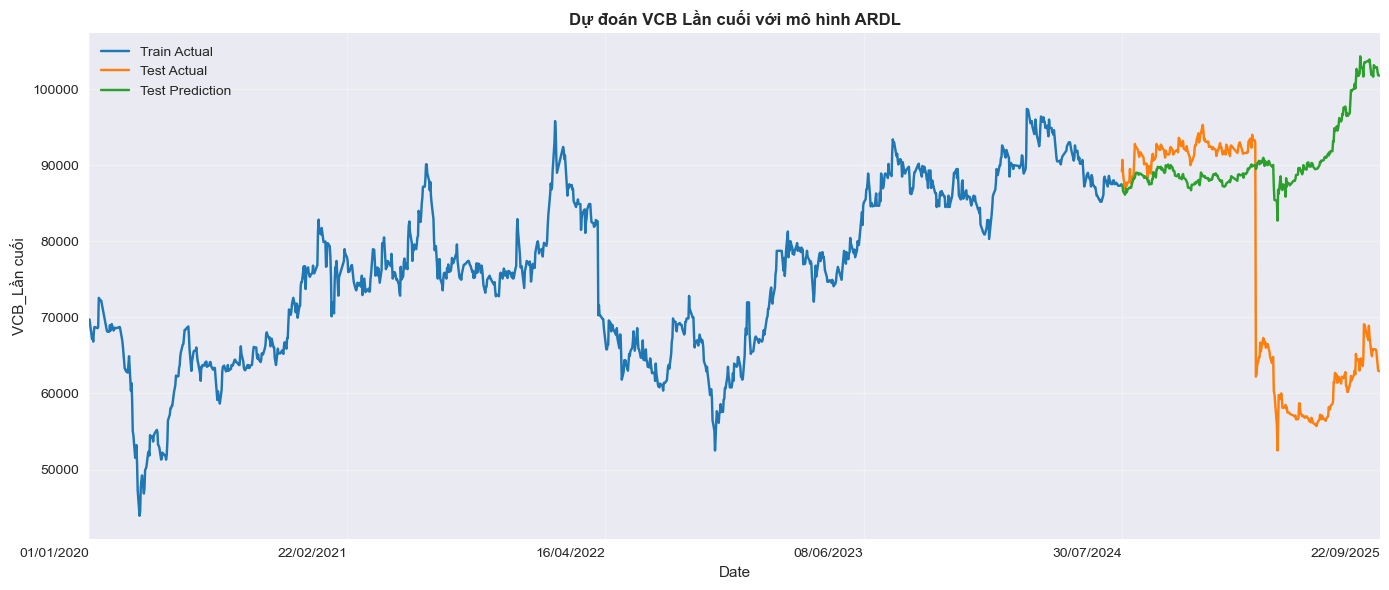

In [62]:
# Tính index từ df_pca gốc
n_train_ardl = len(train_ardl_original)
n_test_ardl = len(y_test_original)

train_start_idx = 0
train_end_idx = n_train_ardl + 1  # +1 vì diff mất 1 dòng

test_start_idx = train_end_idx
test_end_idx = test_start_idx + n_test_ardl

# Lấy dates và values từ df_pca gốc
train_dates = pd.to_datetime(df_pca['Ngày'].iloc[train_start_idx:train_end_idx])
test_dates = pd.to_datetime(df_pca['Ngày'].iloc[test_start_idx:test_end_idx])

y_train_plot = df_pca[target_column].iloc[train_start_idx:train_end_idx]
y_test_plot = df_pca[target_column].iloc[test_start_idx:test_end_idx]

# Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train_dates, y_train_plot, label='Train Actual')
ax.plot(test_dates, y_test_plot, label='Test Actual')
ax.plot(test_dates[:len(y_pred_original_ardl)], y_pred_original_ardl, label='Test Prediction')

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

ax.set_xlabel('Date')
ax.set_ylabel('VCB_Lần cuối')
ax.set_title('Dự đoán VCB Lần cuối với mô hình ARDL', fontweight="bold")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/ardl_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.4. Mô hình LIGHTGBM

In [63]:
def create_lag_features_lgb(df, target_col, lags=[1, 2, 3, 5, 7]):
    df_lagged = df.copy()
    for lag in lags:
        df_lagged[f'{target_col}_lag_{lag}'] = df_lagged[target_col].shift(lag)
    df_lagged = df_lagged.dropna()
    return df_lagged

# Chỉ dùng feature_cols + target
df_lgb = df_pca[feature_cols + [target_column]].copy()
df_lgb_lagged = create_lag_features_lgb(df_lgb, target_column, lags=[1, 2, 3, 5, 7])

# Features và target
lag_features = [col for col in df_lgb_lagged.columns if '_lag_' in col]
X_lgb = df_lgb_lagged[feature_cols + lag_features]
y_lgb = df_lgb_lagged[target_column]

In [64]:
n_total = len(X_lgb)
n_train_lgb = int(n_total * 0.7)
n_val_lgb = int(n_total * 0.1)

X_train_lgb = X_lgb.iloc[:n_train_lgb]
y_train_lgb = y_lgb.iloc[:n_train_lgb]

X_val_lgb = X_lgb.iloc[n_train_lgb:n_train_lgb+n_val_lgb]
y_val_lgb = y_lgb.iloc[n_train_lgb:n_train_lgb+n_val_lgb]

X_test_lgb = X_lgb.iloc[n_train_lgb+n_val_lgb:]
y_test_lgb = y_lgb.iloc[n_train_lgb+n_val_lgb:]

print(f"Train: {len(X_train_lgb)}, Val: {len(X_val_lgb)}, Test: {len(X_test_lgb)}")

Train: 993, Val: 142, Test: 285


In [65]:
scaler_X_lgb = StandardScaler()
scaler_y_lgb = StandardScaler()

X_train_scaled_lgb = scaler_X_lgb.fit_transform(X_train_lgb)
X_val_scaled_lgb = scaler_X_lgb.transform(X_val_lgb)
X_test_scaled_lgb = scaler_X_lgb.transform(X_test_lgb)

y_train_scaled_lgb = scaler_y_lgb.fit_transform(y_train_lgb.values.reshape(-1, 1)).ravel()
y_val_scaled_lgb = scaler_y_lgb.transform(y_val_lgb.values.reshape(-1, 1)).ravel()
y_test_scaled_lgb = scaler_y_lgb.transform(y_test_lgb.values.reshape(-1, 1)).ravel()

In [66]:
train_data_lgb = lgb.Dataset(X_train_scaled_lgb, label=y_train_scaled_lgb)
val_data_lgb = lgb.Dataset(X_val_scaled_lgb, label=y_val_scaled_lgb, reference=train_data_lgb)

In [67]:
# Parameters
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Training với early stopping

model_lgb = lgb.train(
    params_lgb,
    train_data_lgb,
    num_boost_round=1000,
    valid_sets=[train_data_lgb, val_data_lgb],
    valid_names=['train', 'val'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

print("\nĐã huấn luyện mô hình LightGBM")

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0969468	val's rmse: 0.33059
Early stopping, best iteration is:
[90]	train's rmse: 0.100577	val's rmse: 0.324507

Đã huấn luyện mô hình LightGBM


In [68]:
print(f"\nBest iteration: {model_lgb.best_iteration}")


Best iteration: 90


In [69]:
# Predictions (scaled)
y_pred_train_scaled_lgb = model_lgb.predict(X_train_scaled_lgb, num_iteration=model_lgb.best_iteration)
y_pred_val_scaled_lgb = model_lgb.predict(X_val_scaled_lgb, num_iteration=model_lgb.best_iteration)
y_pred_test_scaled_lgb = model_lgb.predict(X_test_scaled_lgb, num_iteration=model_lgb.best_iteration)

# Inverse transform
y_pred_train_lgb = scaler_y_lgb.inverse_transform(y_pred_train_scaled_lgb.reshape(-1, 1)).ravel()
y_pred_val_lgb = scaler_y_lgb.inverse_transform(y_pred_val_scaled_lgb.reshape(-1, 1)).ravel()
y_pred_test_lgb = scaler_y_lgb.inverse_transform(y_pred_test_scaled_lgb.reshape(-1, 1)).ravel()

# Metrics
mae_test_lgb = mean_absolute_error(y_test_lgb, y_pred_test_lgb)
rmse_test_lgb = np.sqrt(mean_squared_error(y_test_lgb, y_pred_test_lgb))
mape_test_lgb = np.mean(np.abs((y_test_lgb - y_pred_test_lgb) / y_test_lgb)) * 100
r2_test_lgb = r2_score(y_test_lgb, y_pred_test_lgb)

print("Đánh giá kết quả mô hình LightGBM:")
print(f"MAE:  {mae_test_lgb:.4f}")
print(f"RMSE: {rmse_test_lgb:.4f}")
print(f"MAPE: {mape_test_lgb:.2f}%")
print(f"R²:   {r2_test_lgb:.4f}")

Đánh giá kết quả mô hình LightGBM:
MAE:  1869.7487
RMSE: 2732.5268
MAPE: 2.32%
R²:   0.9695


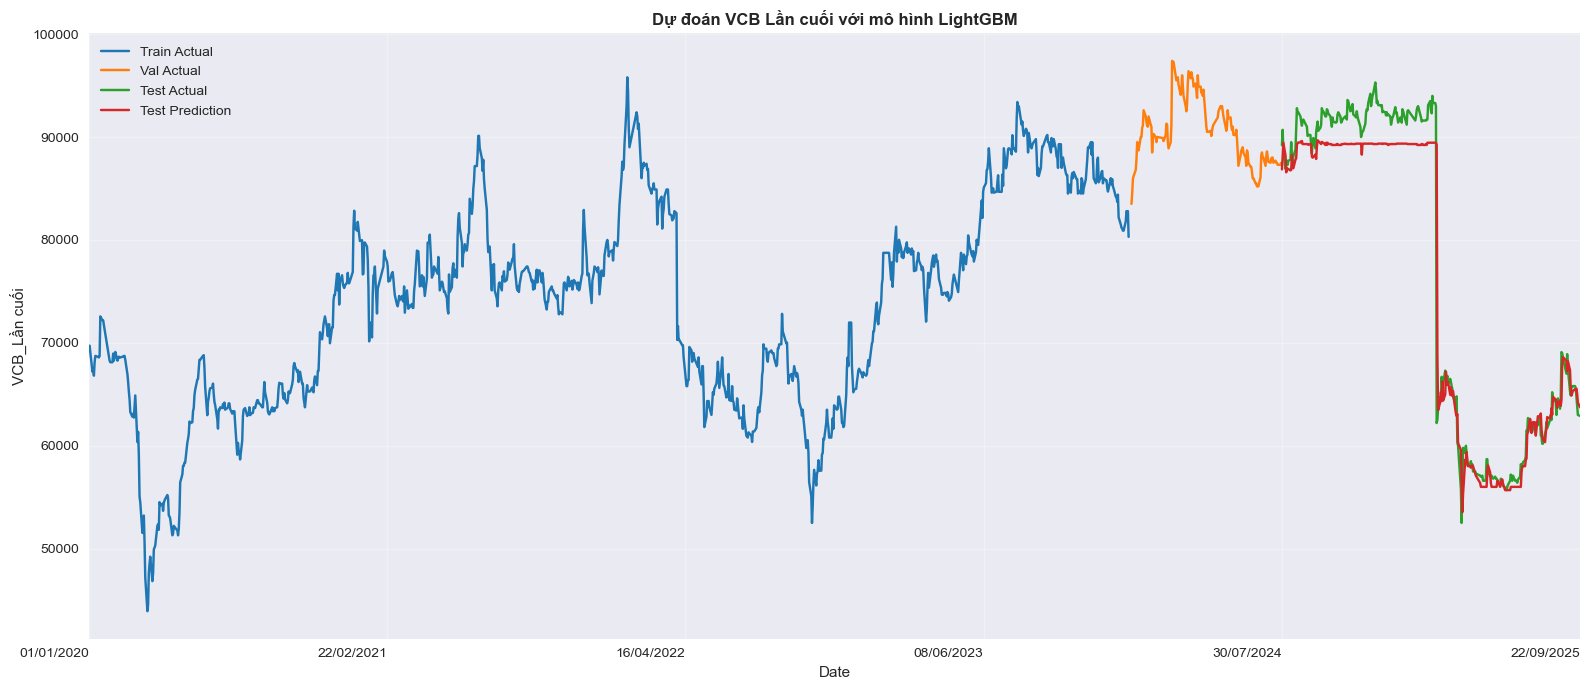

In [70]:
# Get dates (accounting for dropped rows from lagging)
n_dropped = len(df_pca) - len(df_lgb_lagged)

# Lấy giá trị từ df_pca gốc để plot từ 01/01/2020
train_dates_lgb = pd.to_datetime(df_pca['Ngày'].iloc[:n_train_lgb+n_dropped])
val_dates_lgb = pd.to_datetime(df_pca['Ngày'].iloc[n_train_lgb+n_dropped:n_train_lgb+n_val_lgb+n_dropped])
test_dates_lgb = pd.to_datetime(df_pca['Ngày'].iloc[n_train_lgb+n_val_lgb+n_dropped:])

# Dates cho predictions
pred_test_dates = pd.to_datetime(df_pca['Ngày'].iloc[n_train_lgb+n_val_lgb+n_dropped:n_train_lgb+n_val_lgb+n_dropped+len(y_pred_test_lgb)])

y_train_lgb_full = df_pca[target_column].iloc[:n_train_lgb+n_dropped]
y_val_lgb_full = df_pca[target_column].iloc[n_train_lgb+n_dropped:n_train_lgb+n_val_lgb+n_dropped]
y_test_lgb_full = df_pca[target_column].iloc[n_train_lgb+n_val_lgb+n_dropped:]

# Single plot with all data
fig, ax = plt.subplots(figsize=(16, 7))

# Train
ax.plot(train_dates_lgb, y_train_lgb_full, label='Train Actual')

# Validation
ax.plot(val_dates_lgb, y_val_lgb_full, label='Val Actual')

# Test
ax.plot(test_dates_lgb, y_test_lgb_full, label='Test Actual')
ax.plot(pred_test_dates, y_pred_test_lgb, label='Test Prediction')

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

ax.set_xlabel('Date')
ax.set_ylabel('VCB_Lần cuối')
ax.set_title('Dự đoán VCB Lần cuối với mô hình LightGBM', fontweight="bold")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/lightgbm_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.3. Mô hình LSTM

In [71]:
# Split 70/10/20
n_total = len(df_pca)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

X_train_lstm = df_pca[feature_cols].iloc[:n_train].values
X_val_lstm = df_pca[feature_cols].iloc[n_train:n_train+n_val].values
X_test_lstm = df_pca[feature_cols].iloc[n_train+n_val:].values

y_train_lstm = df_pca[target_column].iloc[:n_train].values
y_val_lstm = df_pca[target_column].iloc[n_train:n_train+n_val].values
y_test_lstm = df_pca[target_column].iloc[n_train+n_val:].values

# SCALING - FIT ON TRAIN ONLY
scaler_X_lstm = MinMaxScaler()
scaler_y_lstm = MinMaxScaler()

X_train_scaled = scaler_X_lstm.fit_transform(X_train_lstm)
X_val_scaled = scaler_X_lstm.transform(X_val_lstm)
X_test_scaled = scaler_X_lstm.transform(X_test_lstm)

y_train_scaled = scaler_y_lstm.fit_transform(y_train_lstm.reshape(-1, 1)).ravel()
y_val_scaled = scaler_y_lstm.transform(y_val_lstm.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y_lstm.transform(y_test_lstm.reshape(-1, 1)).ravel()

print(f"Đã chuẩn bị dữ liệu: Train {X_train_scaled.shape}, Val {X_val_scaled.shape}, Test {X_test_scaled.shape}")

Đã chuẩn bị dữ liệu: Train (998, 3), Val (142, 3), Test (287, 3)


In [72]:
def create_sequences(X, y, lookback=10):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback)])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

lookback = 20

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, lookback)

print(f"Sequences: Train {X_train_seq.shape}, Val {X_val_seq.shape}, Test {X_test_seq.shape}")

Sequences: Train (978, 20, 3), Val (122, 20, 3), Test (267, 20, 3)


In [73]:
model_lstm = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, X_train_scaled.shape[1])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1)
], name='LSTM_Model')

model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)
model_lstm.summary()

Model: "LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 20, 64)              │          17,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [74]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)


history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=150,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

print("\nĐã huấn luyện LSTM")

Epoch 1/150


31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0445 - mae: 0.1705 - val_loss: 0.0606 - val_mae: 0.2366
Epoch 2/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0261 - mae: 0.1315 - val_loss: 0.0318 - val_mae: 0.1513
Epoch 3/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0213 - mae: 0.1173 - val_loss: 0.0253 - val_mae: 0.1264
Epoch 4/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0181 - mae: 0.1068 - val_loss: 0.0318 - val_mae: 0.1483
Epoch 5/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0177 - mae: 0.1062 - val_loss: 0.0288 - val_mae: 0.1417
Epoch 6/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0168 - mae: 0.1045 - val_loss: 0.0157 - val_mae: 0.0978
Epoch 7/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0142 - mae: 0.0942 - val_loss: 0.0429 - val_mae: 0.1880
Epoch 8/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0154 - mae: 0.0980 - val_loss: 0.0110 - val_mae: 0.0836
Epoch 9/150
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0125 -

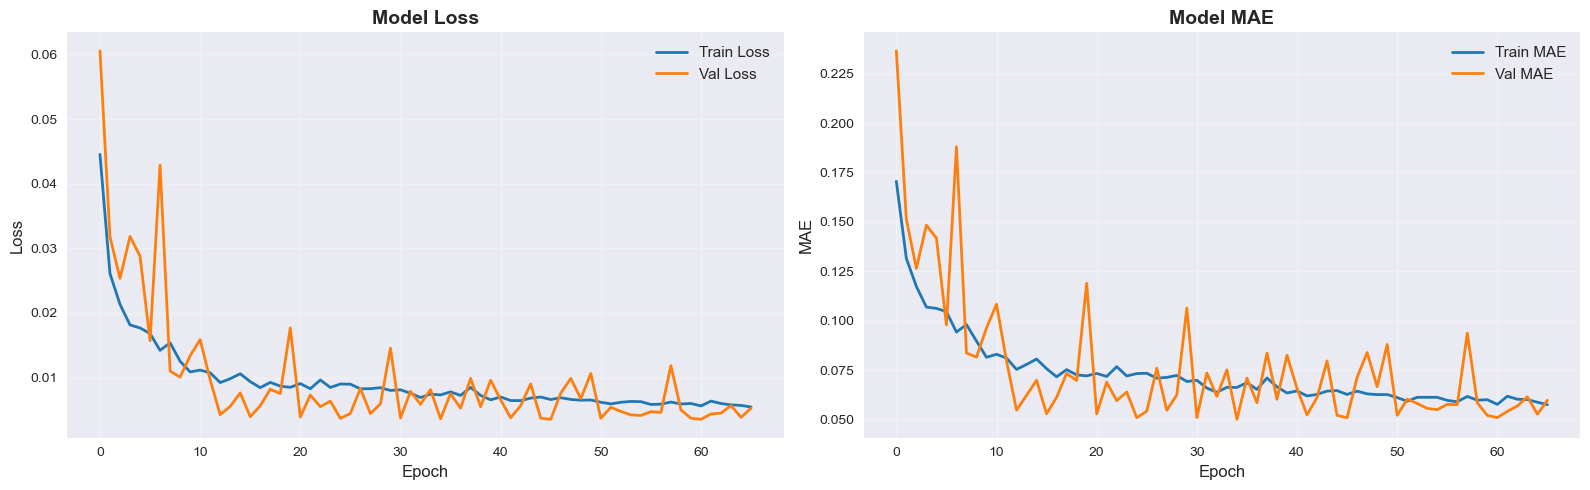

In [75]:

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss
ax1.plot(history.history['loss'], label='Train Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(True, alpha=0.3)

# MAE
ax2.plot(history.history['mae'], label='Train MAE', linewidth=2)
ax2.plot(history.history['val_mae'], label='Val MAE', linewidth=2)
ax2.set_title('Model MAE', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MAE', fontsize=12)
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./images/lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [76]:
# Predictions (scaled)
y_pred_train_scaled = model_lstm.predict(X_train_seq, verbose=0)
y_pred_val_scaled = model_lstm.predict(X_val_seq, verbose=0)
y_pred_test_scaled = model_lstm.predict(X_test_seq, verbose=0)

# Inverse transform
y_pred_train_original = scaler_y_lstm.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
y_pred_val_original = scaler_y_lstm.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).ravel()
y_pred_original = scaler_y_lstm.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

y_train_original = scaler_y_lstm.inverse_transform(y_train_seq.reshape(-1, 1)).ravel()
y_val_original = scaler_y_lstm.inverse_transform(y_val_seq.reshape(-1, 1)).ravel()
y_test_original = scaler_y_lstm.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()

# Metrics
mae_lstm = mean_absolute_error(y_test_original, y_pred_original)
rmse_lstm = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape_lstm = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
r2_lstm = r2_score(y_test_original, y_pred_original)

print("KẾT QUẢ MÔ HÌNH LSTM")
print(f"MAE:  {mae_lstm:,.2f} VND")
print(f"RMSE: {rmse_lstm:,.2f} VND")
print(f"MAPE: {mape_lstm:.2f}%")
print(f"R²:   {r2_lstm:.4f}")

KẾT QUẢ MÔ HÌNH LSTM
MAE:  17,297.32 VND
RMSE: 22,877.60 VND
MAPE: 28.01%
R²:   -1.0903


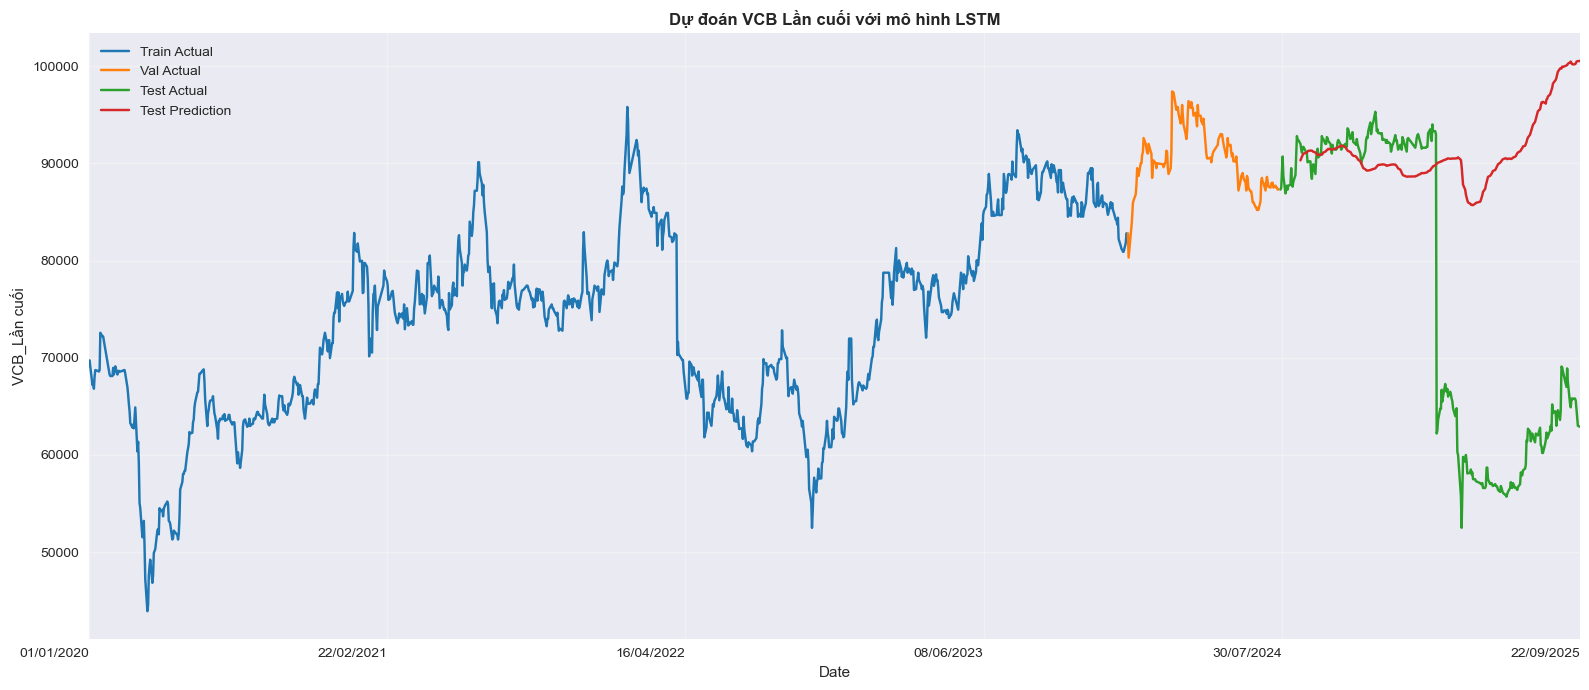

In [77]:
# Lấy dates từ df_pca gốc (bỏ qua lookback)
train_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[:n_train])
val_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train:n_train+n_val])
test_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train+n_val:])

# Lấy giá trị gốc
y_train_full = df_pca[target_column].iloc[:n_train]
y_val_full = df_pca[target_column].iloc[n_train:n_train+n_val]
y_test_full = df_pca[target_column].iloc[n_train+n_val:]

# Dates cho predictions (accounting for lookback)
test_start_idx = n_train + n_val + lookback
test_dates_pred = pd.to_datetime(df_pca['Ngày'].iloc[test_start_idx:test_start_idx+len(y_pred_original)])

# Create plot
fig, ax = plt.subplots(figsize=(16, 7))

# Plot Actuals từ 01/01/2020
ax.plot(train_dates_full, y_train_full, label='Train Actual')
ax.plot(val_dates_full, y_val_full, label='Val Actual')
ax.plot(test_dates_full, y_test_full, label='Test Actual')

# Plot Test Prediction
ax.plot(test_dates_pred, y_pred_original, label='Test Prediction')

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

ax.set_xlabel('Date')
ax.set_ylabel('VCB_Lần cuối')
ax.set_title('Dự đoán VCB Lần cuối với mô hình LSTM', fontweight="bold")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/lstm_combined_plot.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.5. MÔ HÌNH XGBOOST


In [78]:
def create_lag_features(df, target_col, feature_cols, n_lags=3):
    """Tạo lag features cho XGBoost"""
    df_lag = df.copy()
    
    # Chỉ lấy features có trong df (bỏ Cluster nếu có)
    valid_features = [col for col in feature_cols if col in df.columns]
    
    # Lag features cho target
    for lag in range(1, n_lags + 1):
        df_lag[f'{target_col}_lag{lag}'] = df[target_col].shift(lag)
    
    # Lag features cho valid features
    for col in valid_features:
        for lag in range(1, n_lags + 1):
            df_lag[f'{col}_lag{lag}'] = df[col].shift(lag)
    
    df_lag = df_lag.dropna()
    return df_lag

df_lag_xgb = create_lag_features(df_pca, target_column, feature_cols, n_lags=3)

print(f"XGBoost Data với lag features:")
print(f"  Original: {df_pca.shape}")
print(f"  With lags: {df_lag_xgb.shape}")

XGBoost Data với lag features:
  Original: (1427, 5)
  With lags: (1424, 17)


In [79]:
# Split 70% train, 10% val, 20% test
n_total = len(df_lag_xgb)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

train_data = df_lag_xgb.iloc[:n_train]
val_data = df_lag_xgb.iloc[n_train:n_train + n_val]
test_data = df_lag_xgb.iloc[n_train + n_val:]

print(f"\nChia tách dữ liệu cho mô hình Xgboost:")
print(f"  Train: {train_data.shape} ({n_train/n_total*100:.1f}%)")
print(f"  Val:   {val_data.shape} ({n_val/n_total*100:.1f}%)")
print(f"  Test:  {test_data.shape} ({(n_total-n_train-n_val)/n_total*100:.1f}%)")


Chia tách dữ liệu cho mô hình Xgboost:
  Train: (996, 17) (69.9%)
  Val:   (142, 17) (10.0%)
  Test:  (286, 17) (20.1%)


In [80]:
lag_feature_cols = [col for col in df_lag_xgb.columns 
                    if col not in [target_column, 'Ngày'] and 'lag' in col]

X_train_xgb = train_data[lag_feature_cols]
y_train_xgb = train_data[target_column]

X_val_xgb = val_data[lag_feature_cols]
y_val_xgb = val_data[target_column]

X_test_xgb = test_data[lag_feature_cols]
y_test_xgb = test_data[target_column]

print(f"\nXGBoost Features:")
print(f"  Lag features: {len(lag_feature_cols)}")
print(f"  X_train: {X_train_xgb.shape}")
print(f"  X_val:   {X_val_xgb.shape}")
print(f"  X_test:  {X_test_xgb.shape}")


XGBoost Features:
  Lag features: 12
  X_train: (996, 12)
  X_val:   (142, 12)
  X_test:  (286, 12)


In [81]:
start_time = time.time()

model_xgb = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=50,
    eval_metric='rmse'
)

model_xgb.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_val_xgb, y_val_xgb)],
    verbose=False
)

training_time = time.time() - start_time

print(f"\n✓ XGBoost huấn luyện trongtrong {training_time:.2f}s")
print(f"  Iteration tốt nhất: {model_xgb.best_iteration}")
print(f"  Best score: {model_xgb.best_score:.4f}")


✓ XGBoost huấn luyện trongtrong 0.48s
  Iteration tốt nhất: 126
  Best score: 2486.5635


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

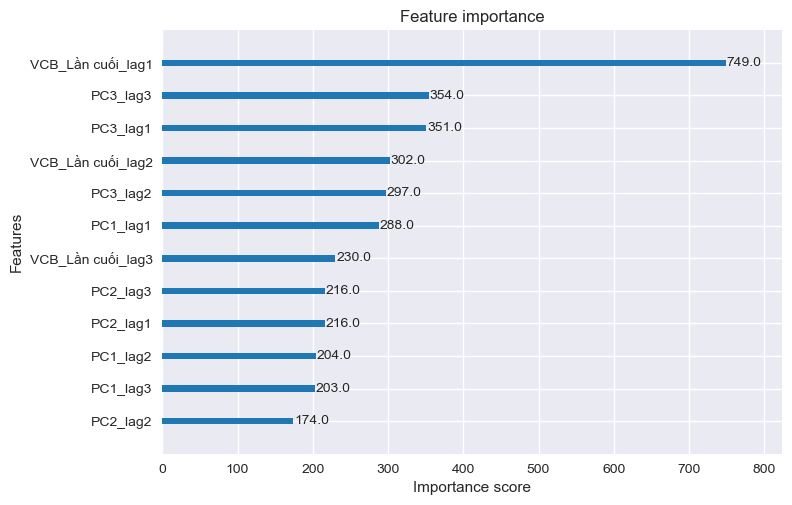

In [82]:
xgb.plot_importance(model_xgb, max_num_features=len(model_xgb.feature_names_in_))

In [83]:
# Predictions
y_pred_train = model_xgb.predict(X_train_xgb)
y_pred_val = model_xgb.predict(X_val_xgb)
y_pred_test = model_xgb.predict(X_test_xgb)

# Train metrics
mae_train = mean_absolute_error(y_train_xgb, y_pred_train)
rmse_train = np.sqrt(mean_squared_error(y_train_xgb, y_pred_train))
r2_train = r2_score(y_train_xgb, y_pred_train)

# Val metrics
mae_val = mean_absolute_error(y_val_xgb, y_pred_val)
rmse_val = np.sqrt(mean_squared_error(y_val_xgb, y_pred_val))
r2_val = r2_score(y_val_xgb, y_pred_val)

# Test metrics
mae_test_xgb = mean_absolute_error(y_test_xgb, y_pred_test)
rmse_test_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_test))
r2_test_xgb= r2_score(y_test_xgb, y_pred_test)

print("\nĐánh giá mô hình XGBoost:")
print(f"\n{'Dataset':<10} {'MAE':<12} {'RMSE':<12} {'R²':<10}")
print(f"{'Train':<10} {mae_train:<12.2f} {rmse_train:<12.2f} {r2_train:<10.4f}")
print(f"{'Val':<10} {mae_val:<12.2f} {rmse_val:<12.2f} {r2_val:<10.4f}")
print(f"{'Test':<10} {mae_test_xgb:<12.2f} {rmse_test_xgb:<12.2f} {r2_test_xgb:<10.4f}")


Đánh giá mô hình XGBoost:

Dataset    MAE          RMSE         R²        
Train      589.49       795.39       0.9933    
Val        1894.50      2486.56      0.4231    
Test       1427.78      2360.56      0.9772    


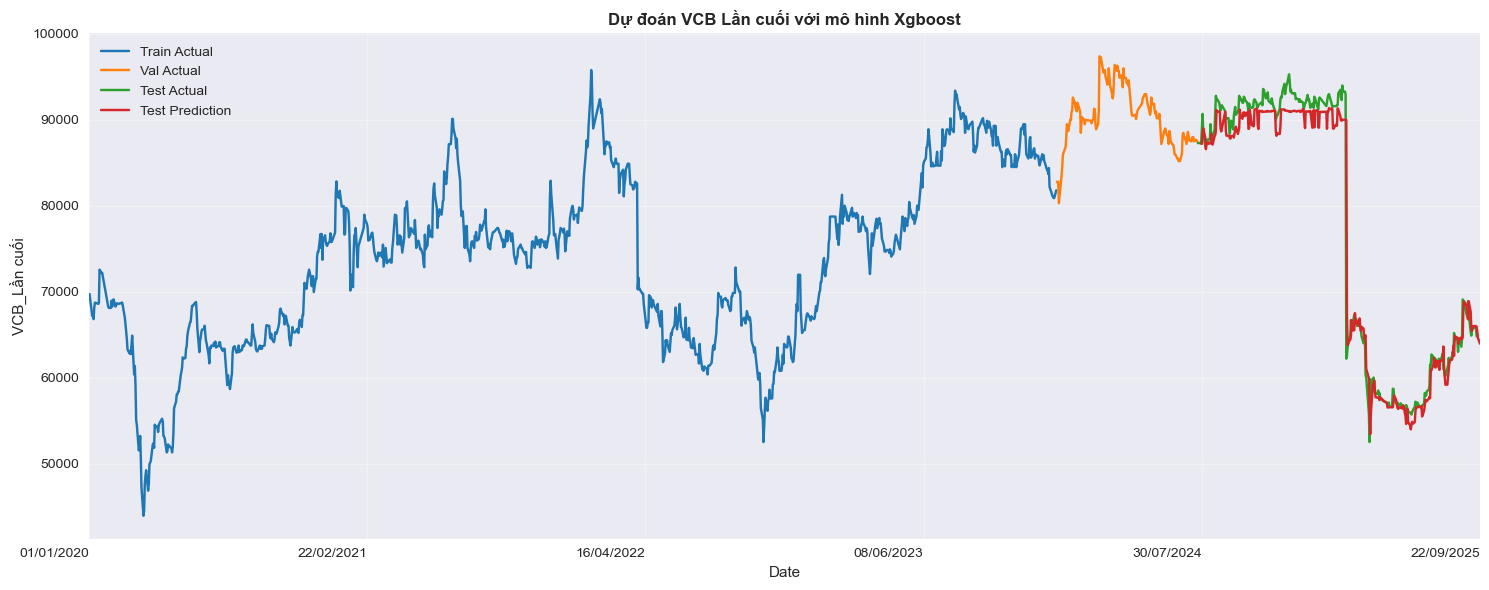

In [84]:
# Lấy dates từ df_pca gốc
n_train_xgb = len(train_data)
n_val_xgb = len(val_data)
n_test_xgb = len(test_data)

train_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[:n_train_xgb])
val_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train_xgb:n_train_xgb+n_val_xgb])
test_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train_xgb+n_val_xgb:n_train_xgb+n_val_xgb+n_test_xgb])

y_train_full = df_pca[target_column].iloc[:n_train_xgb]
y_val_full = df_pca[target_column].iloc[n_train_xgb:n_train_xgb+n_val_xgb]
y_test_full = df_pca[target_column].iloc[n_train_xgb+n_val_xgb:n_train_xgb+n_val_xgb+n_test_xgb]

plt.figure(figsize=(15, 6))

dates_train = train_data['Ngày']
dates_val = val_data['Ngày']
dates_test = test_data['Ngày']

plt.plot(train_dates_full, y_train_full, label='Train Actual')
plt.plot(val_dates_full, y_val_full, label='Val Actual')
plt.plot(test_dates_full, y_test_full, label='Test Actual')
plt.plot(dates_test, y_pred_test, label='Test Prediction')

# Format date axis
ax = plt.gca()

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.xlabel('Date')
plt.ylabel('VCB_Lần cuối')
plt.title('Dự đoán VCB Lần cuối với mô hình Xgboost', fontweight ="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/xgboost_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.6. MÔ HÌNH RANDOM FOREST


In [85]:
# Split 70% train, 10% val, 20% test
n_total = len(df_pca)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

train_data_rf = df_pca.iloc[:n_train]
val_data_rf = df_pca.iloc[n_train:n_train + n_val]
test_data_rf = df_pca.iloc[n_train + n_val:]

print(f"Chia tách dữ liệu cho mô hình Random Forest:")
print(f"  Train: {train_data_rf.shape} ({n_train/n_total*100:.1f}%)")
print(f"  Val:   {val_data_rf.shape} ({n_val/n_total*100:.1f}%)")
print(f"  Test:  {test_data_rf.shape} ({(n_total-n_train-n_val)/n_total*100:.1f}%)")

Chia tách dữ liệu cho mô hình Random Forest:
  Train: (998, 5) (69.9%)
  Val:   (142, 5) (10.0%)
  Test:  (287, 5) (20.1%)


In [86]:
# Features và target
X_train_rf = train_data_rf[feature_cols]
y_train_rf = train_data_rf[target_column]

X_val_rf = val_data_rf[feature_cols]
y_val_rf = val_data_rf[target_column]

X_test_rf = test_data_rf[feature_cols]
y_test_rf = test_data_rf[target_column]

print(f"\nĐã chuẩn bị dữ liệu cho mô hình Random Forest:")
print(f"  Features: {len(feature_cols)}")
print(f"  X_train: {X_train_rf.shape}")
print(f"  X_val:   {X_val_rf.shape}")
print(f"  X_test:  {X_test_rf.shape}")


Đã chuẩn bị dữ liệu cho mô hình Random Forest:
  Features: 3
  X_train: (998, 3)
  X_val:   (142, 3)
  X_test:  (287, 3)


In [87]:
params_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
tscv = TimeSeriesSplit(n_splits=3)

clf_rf = RandomizedSearchCV(
    estimator=model_rf,
    param_distributions=params_rf,
    n_iter=20,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

start_time = time.time()
clf_rf.fit(X_train_rf, y_train_rf)
training_time_rf = time.time() - start_time

print(f"Best params: {clf_rf.best_params_}")
print(f"Training time: {training_time_rf:.2f} seconds")

Best params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}
Training time: 11.82 seconds


In [88]:
final_model_rf = RandomForestRegressor(**clf_rf.best_params_, random_state=42)
final_model_rf.fit(X_train_rf, y_train_rf)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

In [89]:
print(f"\nRandom Forest huấn luyện trong {training_time_rf:.2f}s")
print(f"n_estimators: {final_model_rf.n_estimators}")
print(f"max_depth: {final_model_rf.max_depth}")


Random Forest huấn luyện trong 11.82s
n_estimators: 100
max_depth: 10


In [90]:
# Predictions
y_pred_train_rf = final_model_rf.predict(X_train_rf)
y_pred_val_rf = final_model_rf.predict(X_val_rf)
y_pred_test_rf = final_model_rf.predict(X_test_rf)

# Train metrics
mae_train = mean_absolute_error(y_train_rf, y_pred_train_rf)
rmse_train = np.sqrt(mean_squared_error(y_train_rf, y_pred_train_rf))
r2_train = r2_score(y_train_rf, y_pred_train_rf)

# Val metrics
mae_val = mean_absolute_error(y_val_rf, y_pred_val_rf)
rmse_val = np.sqrt(mean_squared_error(y_val_rf, y_pred_val_rf))
r2_val = r2_score(y_val_rf, y_pred_val_rf)

# Test metrics
mae_test_rf = mean_absolute_error(y_test_rf, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_test_rf))
r2_test_rf = r2_score(y_test_rf, y_pred_test_rf)

print("\nĐánh giá mô hình Random Forest:")
print(f"\n{'Dataset':<10} {'MAE':<12} {'RMSE':<12} {'R²':<10}")
print(f"{'Train':<10} {mae_train:<12.2f} {rmse_train:<12.2f} {r2_train:<10.4f}")
print(f"{'Val':<10} {mae_val:<12.2f} {rmse_val:<12.2f} {r2_val:<10.4f}")
print(f"{'Test':<10} {mae_test_rf:<12.2f} {rmse_test_rf:<12.2f} {r2_test_rf:<10.4f}")


Đánh giá mô hình Random Forest:

Dataset    MAE          RMSE         R²        
Train      1179.16      1795.49      0.9659    
Val        3567.74      4474.03      -0.8095   
Test       13137.46     17182.89     -0.2094   


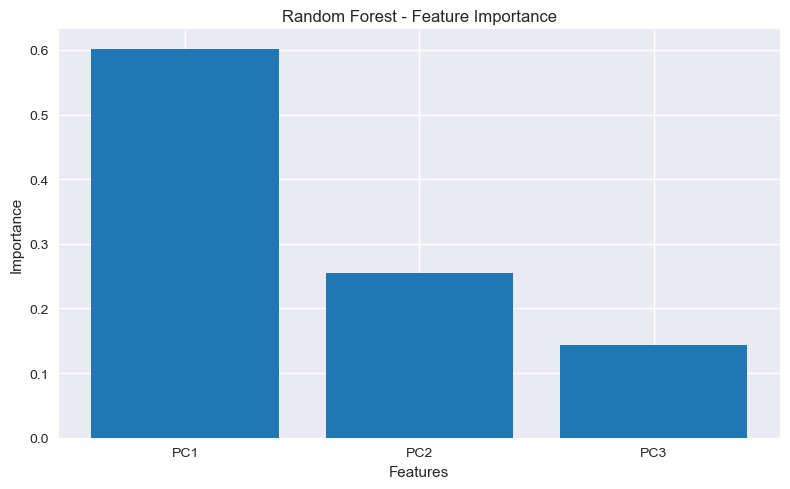

In [91]:
plt.figure(figsize=(8, 5))
plt.bar(feature_cols, final_model_rf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Random Forest - Feature Importance')
plt.tight_layout()
plt.savefig('./images/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

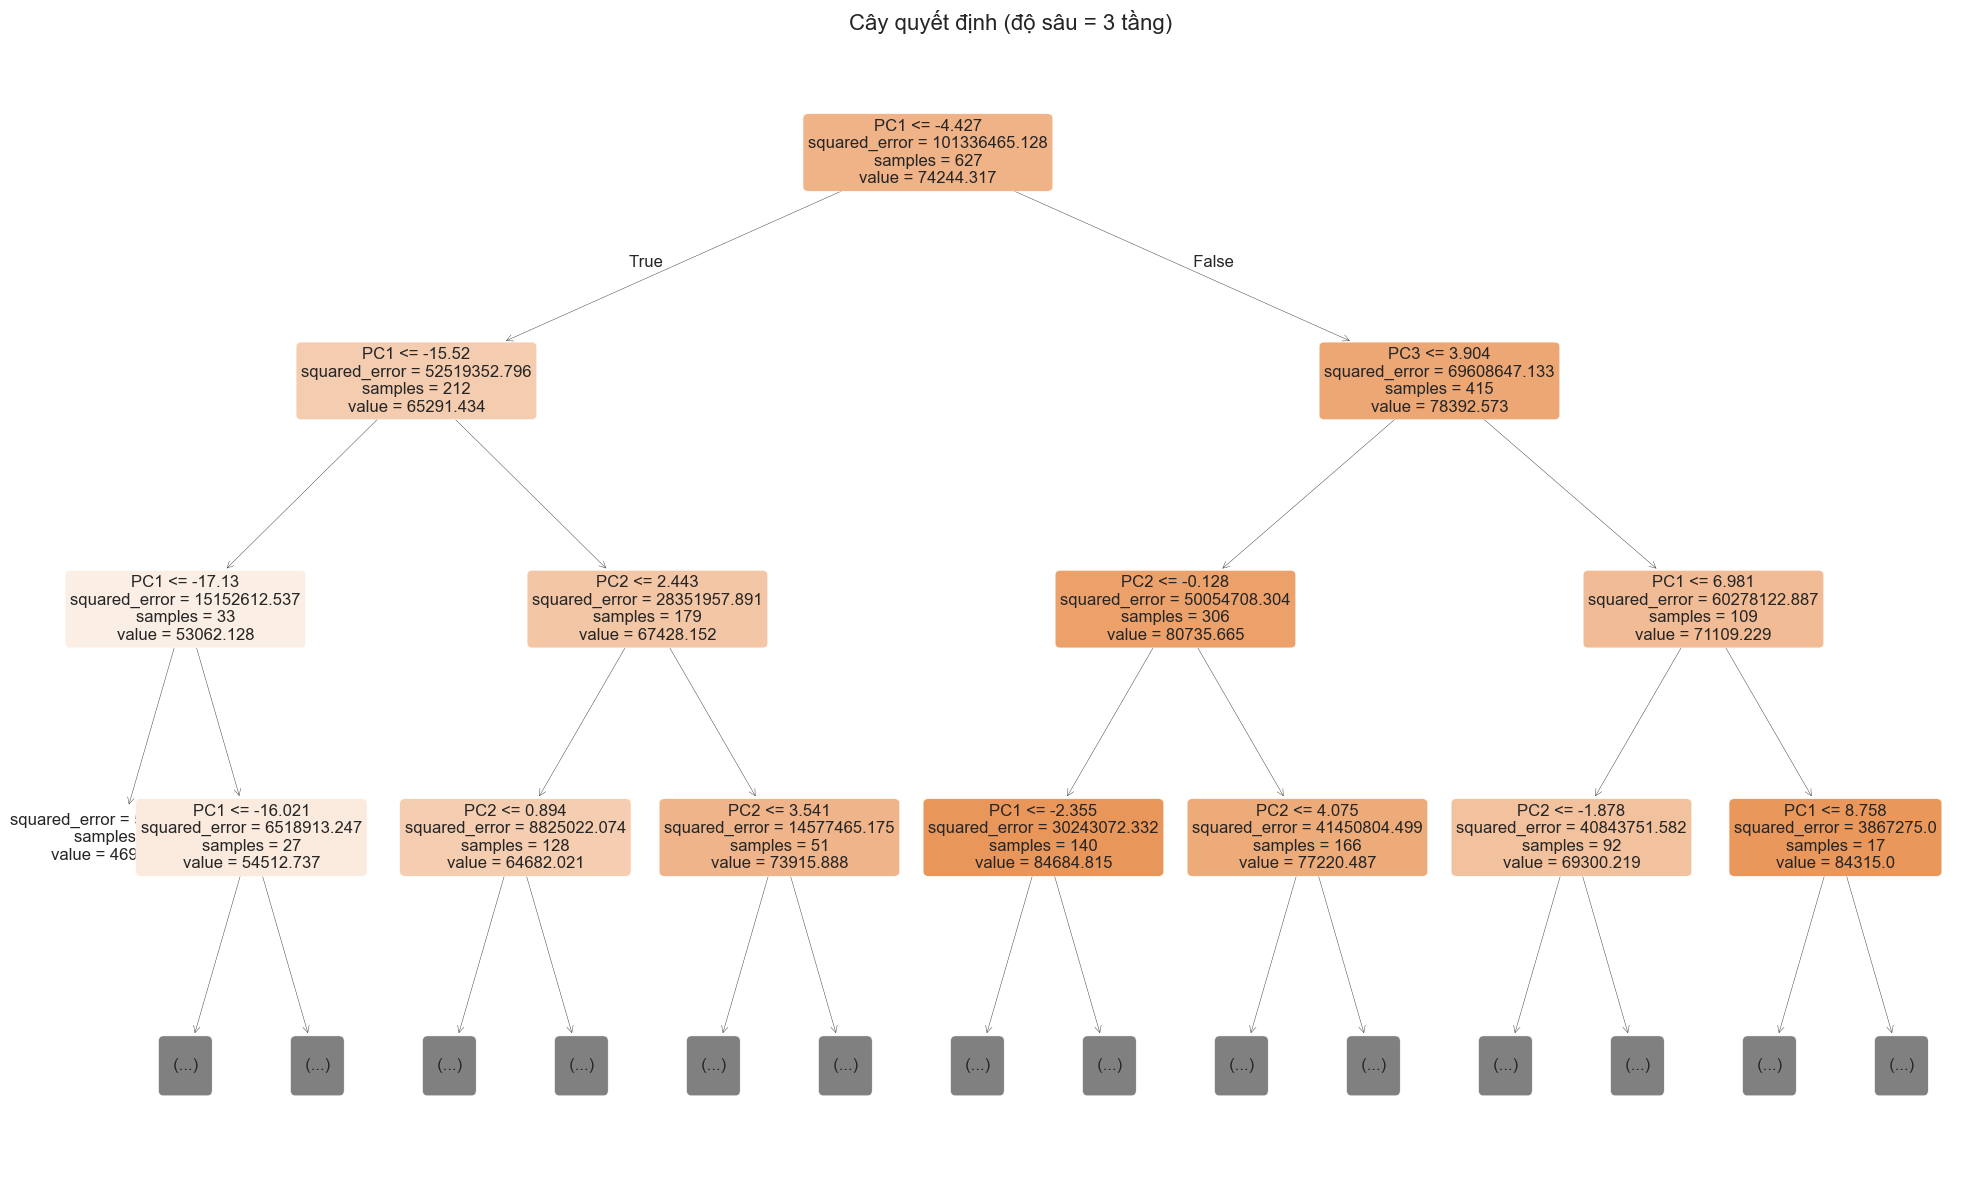

In [92]:
plt.figure(figsize=(20, 12))
plot_tree(final_model_rf.estimators_[0], 
          feature_names=X_train_rf.columns,
          filled=True,
          rounded=True,
          fontsize=12,
          max_depth=3)  
plt.title("Cây quyết định (độ sâu = 3 tầng)", fontsize=16)
plt.tight_layout()
plt.savefig('./images/decision_tree_architecture.png', dpi=300, bbox_inches='tight')
plt.show()

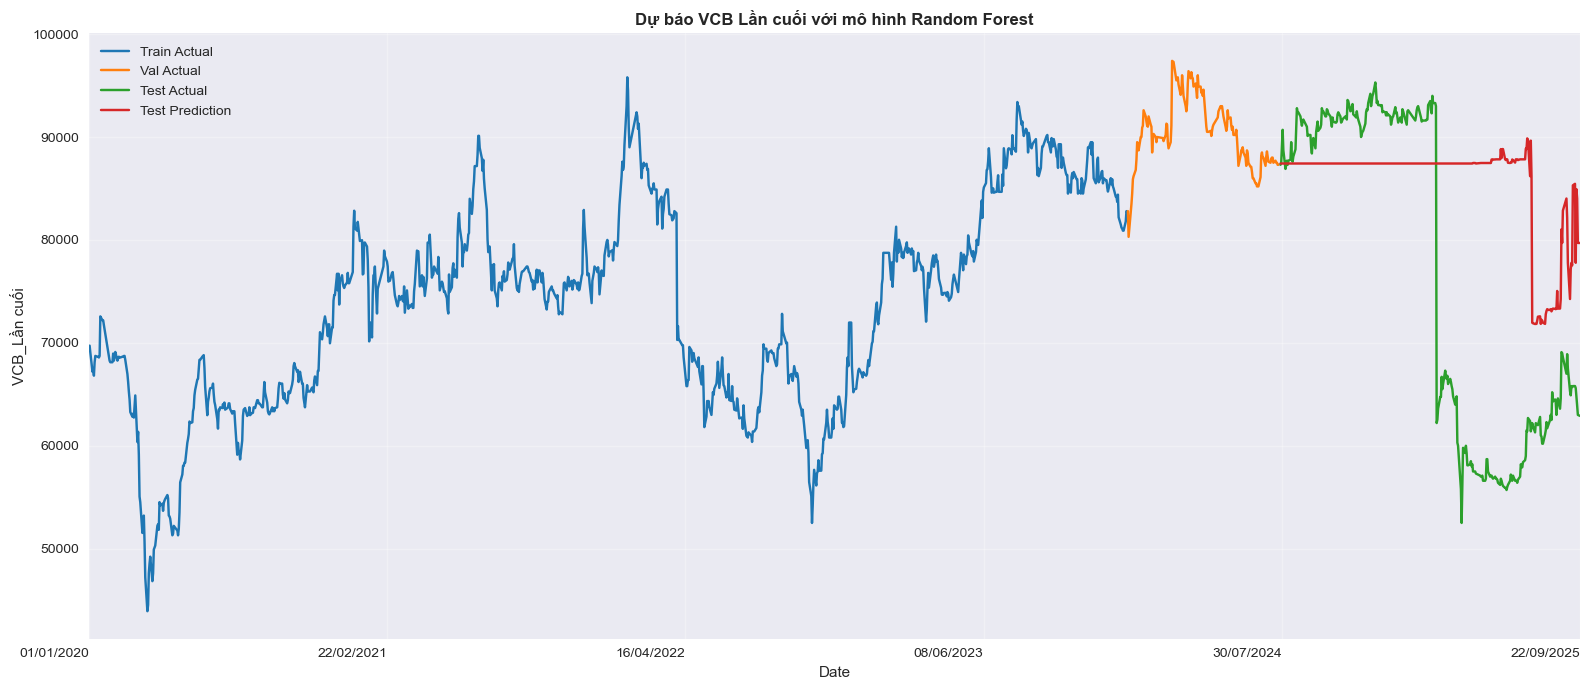

In [93]:
# Lấy dates từ df_pca gốc
n_train_rf = len(train_data_rf)
n_val_rf = len(val_data_rf)
n_test_rf = len(test_data_rf)

train_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[:n_train_rf])
val_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train_rf:n_train_rf+n_val_rf])
test_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train_rf+n_val_rf:n_train_rf+n_val_rf+n_test_rf])

y_train_full = df_pca[target_column].iloc[:n_train_rf]
y_val_full = df_pca[target_column].iloc[n_train_rf:n_train_rf+n_val_rf]
y_test_full = df_pca[target_column].iloc[n_train_rf+n_val_rf:n_train_rf+n_val_rf+n_test_rf]

plt.figure(figsize=(16, 7))

dates_train = train_data_rf['Ngày']
dates_val = val_data_rf['Ngày']
dates_test = test_data_rf['Ngày']

plt.plot(train_dates_full, y_train_full, label='Train Actual')
plt.plot(val_dates_full, y_val_full, label='Val Actual')
plt.plot(test_dates_full, y_test_full, label='Test Actual')
plt.plot(dates_test, y_pred_test_rf, label='Test Prediction')

# Format date axis
ax = plt.gca()
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.xlabel('Date')
plt.ylabel('VCB_Lần cuối')
plt.title('Dự báo VCB Lần cuối với mô hình Random Forest', fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/random_forest_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.7. MÔ HÌNH GRU

In [94]:
# Split 70% train, 10% val, 20% test
n_total = len(df_pca)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

X_train_gru = df_pca[feature_cols].iloc[:n_train].values
X_val_gru = df_pca[feature_cols].iloc[n_train:n_train+n_val].values
X_test_gru = df_pca[feature_cols].iloc[n_train+n_val:].values

y_train_gru = df_pca[target_column].iloc[:n_train].values
y_val_gru = df_pca[target_column].iloc[n_train:n_train+n_val].values
y_test_gru = df_pca[target_column].iloc[n_train+n_val:].values

print(f"Chia dữ liệu cho mô hình GRU:")
print(f"  Train: {X_train_gru.shape}")
print(f"  Val:   {X_val_gru.shape}")
print(f"  Test:  {X_test_gru.shape}")

Chia dữ liệu cho mô hình GRU:
  Train: (998, 3)
  Val:   (142, 3)
  Test:  (287, 3)


In [95]:
scaler_X_gru = MinMaxScaler()
scaler_y_gru = MinMaxScaler()

X_train_scaled_gru = scaler_X_gru.fit_transform(X_train_gru)
X_val_scaled_gru = scaler_X_gru.transform(X_val_gru)
X_test_scaled_gru = scaler_X_gru.transform(X_test_gru)

y_train_scaled_gru = scaler_y_gru.fit_transform(y_train_gru.reshape(-1, 1)).ravel()
y_val_scaled_gru = scaler_y_gru.transform(y_val_gru.reshape(-1, 1)).ravel()
y_test_scaled_gru = scaler_y_gru.transform(y_test_gru.reshape(-1, 1)).ravel()

print("Đã chuẩn hóa dữ liệu trên")

Đã chuẩn hóa dữ liệu trên


In [96]:
def create_sequences(X, y, lookback=10):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:(i + lookback)])
        ys.append(y[i + lookback])
    return np.array(Xs), np.array(ys)

lookback_gru = 10

X_train_seq_gru, y_train_seq_gru = create_sequences(X_train_scaled_gru, y_train_scaled_gru, lookback_gru)
X_val_seq_gru, y_val_seq_gru = create_sequences(X_val_scaled_gru, y_val_scaled_gru, lookback_gru)
X_test_seq_gru, y_test_seq_gru = create_sequences(X_test_scaled_gru, y_test_scaled_gru, lookback_gru)

print(f"\n Đã tạo sequence với lookback {lookback_gru}:")
print(f"  Train: {X_train_seq_gru.shape}, {y_train_seq_gru.shape}")
print(f"  Val:   {X_val_seq_gru.shape}, {y_val_seq_gru.shape}")
print(f"  Test:  {X_test_seq_gru.shape}, {y_test_seq_gru.shape}")


 Đã tạo sequence với lookback 10:
  Train: (988, 10, 3), (988,)
  Val:   (132, 10, 3), (132,)
  Test:  (277, 10, 3), (277,)


In [97]:
model_gru = Sequential([
    GRU(64, return_sequences=True, input_shape=(lookback, len(feature_cols))),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
], name='GRU_Model')

model_gru.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("\nKiến trúc mô hình GRU:")
model_gru.summary()


Kiến trúc mô hình GRU:


Model: "GRU_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 20, 64)              │          13,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 20, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,201 (90.63 KB)

 Trainable params: 23,201 (90.63 KB)

 Non-trainable params: 0 (0.00 B)

In [98]:
early_stop_gru = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history_gru = model_gru.fit(
    X_train_seq_gru, y_train_seq_gru,
    validation_data=(X_val_seq_gru, y_val_seq_gru),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_gru],
    verbose=1
)

print("\nĐã train xong mô hình GRU")

Epoch 1/100


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 0.0551 - mae: 0.1830 - val_loss: 0.1054 - val_mae: 0.3183
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0255 - mae: 0.1296 - val_loss: 0.0130 - val_mae: 0.0992
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0180 - mae: 0.1084 - val_loss: 0.0597 - val_mae: 0.2146
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0163 - mae: 0.1013 - val_loss: 0.0714 - val_mae: 0.2401
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0164 - mae: 0.1037 - val_loss: 0.0728 - val_mae: 0.2405
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0141 - mae: 0.0949 - val_loss: 0.1136 - val_mae: 0.3117
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0140 - mae: 0.0937 - val_loss: 0.0930 - val_mae: 0.2764
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0139 - mae: 0.0936 - val_loss: 0.0866 - val_mae: 0.2663
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0120 -

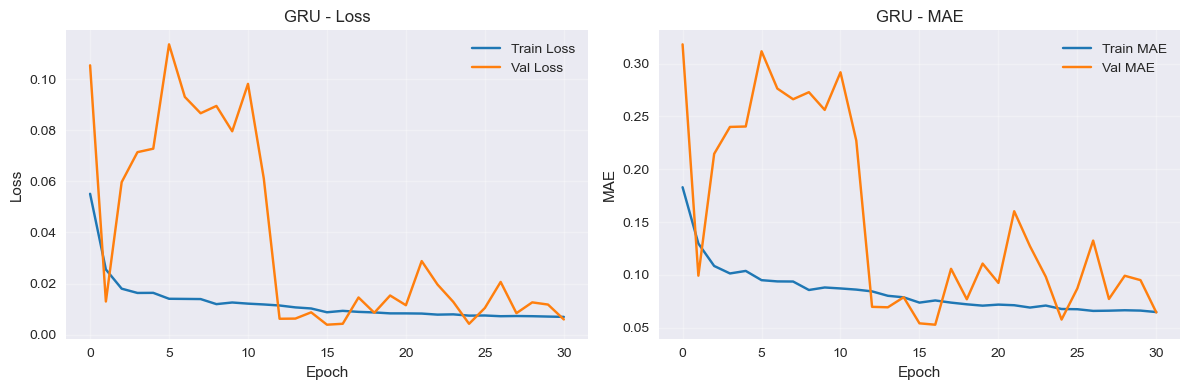

In [99]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Val Loss')
plt.title('GRU - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_gru.history['mae'], label='Train MAE')
plt.plot(history_gru.history['val_mae'], label='Val MAE')
plt.title('GRU - MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./images/gru_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [100]:
# Predict (scaled)
y_pred_train_scaled = model_gru.predict(X_train_seq_gru, verbose=0)
y_pred_val_scaled = model_gru.predict(X_val_seq_gru, verbose=0)
y_pred_test_scaled = model_gru.predict(X_test_seq_gru, verbose=0)

# Inverse transform
y_pred_train_gru = scaler_y_gru.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
y_pred_val_gru = scaler_y_gru.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).ravel()
y_pred_test_gru = scaler_y_gru.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

y_train_original_gru = scaler_y_gru.inverse_transform(y_train_seq_gru.reshape(-1, 1)).ravel()
y_val_original_gru = scaler_y_gru.inverse_transform(y_val_seq_gru.reshape(-1, 1)).ravel()
y_test_original_gru = scaler_y_gru.inverse_transform(y_test_seq_gru.reshape(-1, 1)).ravel()

# Train metrics
mae_train = mean_absolute_error(y_train_original_gru, y_pred_train_gru)
rmse_train = np.sqrt(mean_squared_error(y_train_original_gru, y_pred_train_gru))
r2_train = r2_score(y_train_original_gru, y_pred_train_gru)

# Val metrics
mae_val = mean_absolute_error(y_val_original_gru, y_pred_val_gru)
rmse_val = np.sqrt(mean_squared_error(y_val_original_gru, y_pred_val_gru))
r2_val = r2_score(y_val_original_gru, y_pred_val_gru)

# Test metrics
mae_test_gru = mean_absolute_error(y_test_original_gru, y_pred_test_gru)
rmse_test_gru = np.sqrt(mean_squared_error(y_test_original_gru, y_pred_test_gru))
r2_test_gru = r2_score(y_test_original_gru, y_pred_test_gru)

print("\nĐánh giá mô hình GRU:")
print(f"\n{'Dataset':<10} {'MAE':<12} {'RMSE':<12} {'R²':<10}")
print(f"{'Train':<10} {mae_train:<12.2f} {rmse_train:<12.2f} {r2_train:<10.4f}")
print(f"{'Val':<10} {mae_val:<12.2f} {rmse_val:<12.2f} {r2_val:<10.4f}")
print(f"{'Test':<10} {mae_test_gru:<12.2f} {rmse_test_gru:<12.2f} {r2_test_gru:<10.4f}")


Đánh giá mô hình GRU:

Dataset    MAE          RMSE         R²        
Train      3451.97      4611.89      0.7766    
Val        2802.60      3246.34      -0.1188   
Test       17565.77     24301.54     -1.3793   


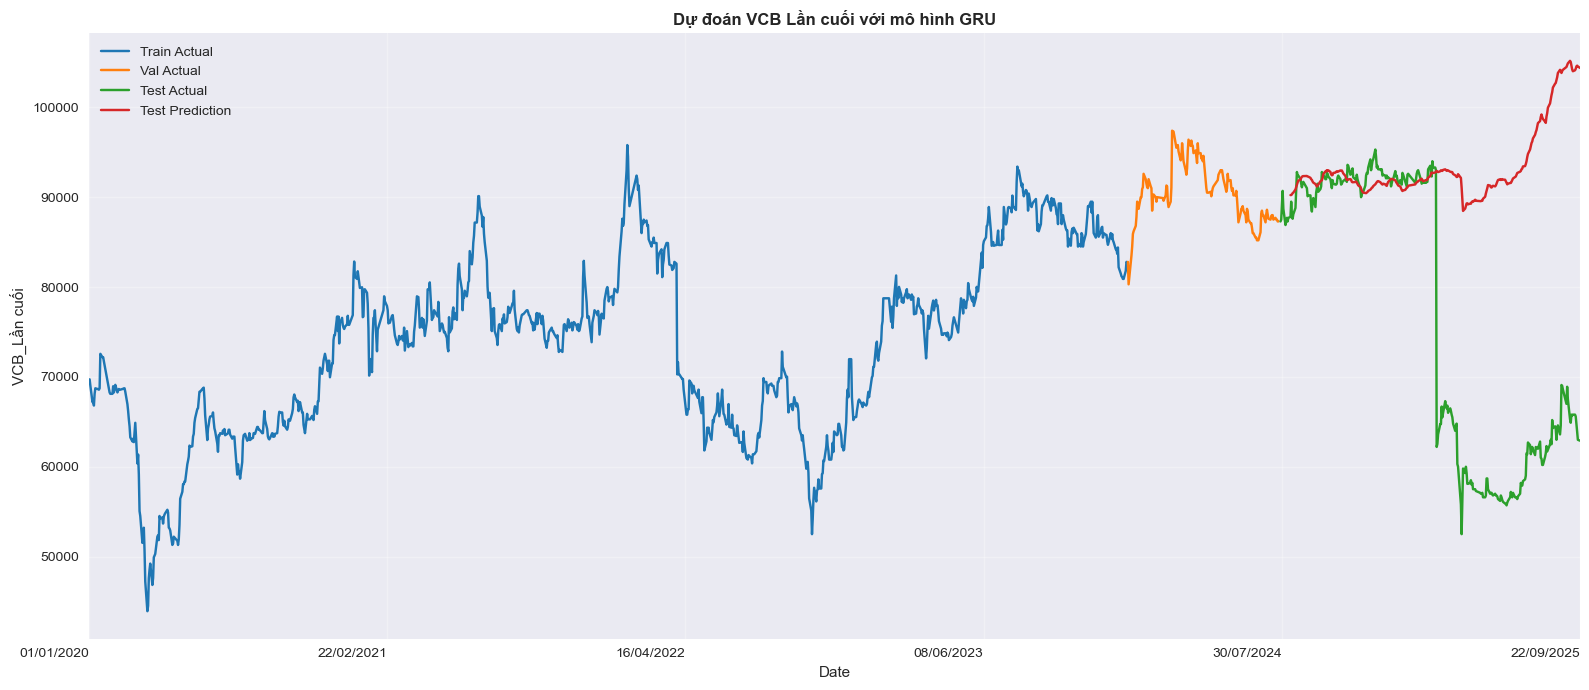

In [101]:
# Lấy dates từ df_pca gốc
train_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[:n_train])
val_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train:n_train+n_val])
test_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train+n_val:])

y_train_full = df_pca[target_column].iloc[:n_train]
y_val_full = df_pca[target_column].iloc[n_train:n_train+n_val]
y_test_full = df_pca[target_column].iloc[n_train+n_val:]

# Dates cho predictions (accounting for lookback)
test_start_idx = n_train + n_val + lookback_gru
test_dates_pred = pd.to_datetime(df_pca['Ngày'].iloc[test_start_idx:test_start_idx+len(y_pred_test_gru)])

plt.figure(figsize=(16, 7))

train_start = lookback_gru
train_end = n_train
val_start = n_train + lookback_gru
val_end = n_train + n_val
test_start = n_train + n_val + lookback_gru
test_end = test_start + len(y_test_original_gru)

dates_train = df_pca['Ngày'].iloc[train_start:train_end]
dates_val = df_pca['Ngày'].iloc[val_start:val_end]
dates_test = df_pca['Ngày'].iloc[test_start:test_end]

y_train_plot = df_pca[target_column].iloc[train_start:train_end]
y_val_plot = df_pca[target_column].iloc[val_start:val_end]

# Plot từ 01/01/2020
plt.plot(train_dates_full, y_train_full, label='Train Actual')
plt.plot(val_dates_full, y_val_full, label='Val Actual')
plt.plot(test_dates_full, y_test_full, label='Test Actual')
plt.plot(test_dates_pred, y_pred_test_gru, label='Test Prediction')

# Format date axis
ax = plt.gca()

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.xlabel('Date')
plt.ylabel('VCB_Lần cuối')
plt.title('Dự đoán VCB Lần cuối với mô hình GRU', fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/gru_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

### 6.8. Mô hình Mạng Neuron (Neuron Network)

In [102]:
# Split 70% train, 10% val, 20% test
n_total = len(df_pca)
n_train = int(n_total * 0.7)
n_val = int(n_total * 0.1)

train_data_nn = df_pca.iloc[:n_train]
val_data_nn = df_pca.iloc[n_train:n_train + n_val]
test_data_nn = df_pca.iloc[n_train + n_val:]

print(f"Chia tách dữ liêu cho mô hình mạng Neuron:")
print(f"  Train: {train_data_nn.shape} ({n_train/n_total*100:.1f}%)")
print(f"  Val:   {val_data_nn.shape} ({n_val/n_total*100:.1f}%)")
print(f"  Test:  {test_data_nn.shape} ({(n_total-n_train-n_val)/n_total*100:.1f}%)")

Chia tách dữ liêu cho mô hình mạng Neuron:
  Train: (998, 5) (69.9%)
  Val:   (142, 5) (10.0%)
  Test:  (287, 5) (20.1%)


In [103]:
X_train_mlp = train_data_nn[feature_cols].values
y_train_mlp = train_data_nn[target_column].values

X_val_mlp = val_data_nn[feature_cols].values
y_val_mlp = val_data_nn[target_column].values

X_test_mlp = test_data_nn[feature_cols].values
y_test_mlp = test_data_nn[target_column].values

# Scale
scaler_X_mlp = StandardScaler()
scaler_y_mlp = StandardScaler()

X_train_scaled_mlp = scaler_X_mlp.fit_transform(X_train_mlp)
X_val_scaled_mlp = scaler_X_mlp.transform(X_val_mlp)
X_test_scaled_mlp = scaler_X_mlp.transform(X_test_mlp)

y_train_scaled_mlp = scaler_y_mlp.fit_transform(y_train_mlp.reshape(-1, 1)).ravel()
y_val_scaled_mlp = scaler_y_mlp.transform(y_val_mlp.reshape(-1, 1)).ravel()
y_test_scaled_mlp = scaler_y_mlp.transform(y_test_mlp.reshape(-1, 1)).ravel()

print(f"\nĐã chuẩn bị dữ liệu cho mô hình Neural Network:")
print(f"  Features: {len(feature_cols)}")
print(f"  X_train: {X_train_scaled_mlp.shape}")
print(f"  X_val:   {X_val_scaled_mlp.shape}")
print(f"  X_test:  {X_test_scaled_mlp.shape}")


Đã chuẩn bị dữ liệu cho mô hình Neural Network:
  Features: 3
  X_train: (998, 3)
  X_val:   (142, 3)
  X_test:  (287, 3)


In [104]:
param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (100, 50, 25), (150, 100, 50)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}

mlp_grid = MLPRegressor(
    solver='adam',
    max_iter=500,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)


grid_search = GridSearchCV(
    mlp_grid,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled_mlp, y_train_scaled_mlp)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=MLPRegressor(early_stopping=True, max_iter=500,
                                    random_state=42),
             n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (100, 50),
                                                (100, 50, 25), (150, 100, 50)],
                         'learning_rate_init': [0.001, 0.01]},
             scoring='neg_mean_absolute_error', verbose=1)

In [105]:
print("\nTham số tốt nhất tìm được:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# best model
mlp_model = grid_search.best_estimator_


Tham số tốt nhất tìm được:
  activation: relu
  alpha: 0.0001
  hidden_layer_sizes: (150, 100, 50)
  learning_rate_init: 0.01


In [106]:
print(f"\nĐã huấn luyện mô hình Neuron Network")
print(f"  Iterations: {mlp_model.n_iter_}")
print(f"  Loss: {mlp_model.loss_:.4f}")


Đã huấn luyện mô hình Neuron Network
  Iterations: 50
  Loss: 0.0370


In [107]:
# Predict (scaled)
y_pred_train_scaled = mlp_model.predict(X_train_scaled_mlp)
y_pred_val_scaled = mlp_model.predict(X_val_scaled_mlp)
y_pred_test_scaled = mlp_model.predict(X_test_scaled_mlp)

# Inverse transform
y_pred_train_mlp = scaler_y_mlp.inverse_transform(y_pred_train_scaled.reshape(-1, 1)).ravel()
y_pred_val_mlp = scaler_y_mlp.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).ravel()
y_pred_test_mlp = scaler_y_mlp.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).ravel()

# Train metrics
mae_train = mean_absolute_error(y_train_mlp, y_pred_train_mlp)
rmse_train = np.sqrt(mean_squared_error(y_train_mlp, y_pred_train_mlp))
r2_train = r2_score(y_train_mlp, y_pred_train_mlp)

# Val metrics
mae_val = mean_absolute_error(y_val_mlp, y_pred_val_mlp)
rmse_val = np.sqrt(mean_squared_error(y_val_mlp, y_pred_val_mlp))
r2_val = r2_score(y_val_mlp, y_pred_val_mlp)

# Test metrics
mae_test_nn = mean_absolute_error(y_test_mlp, y_pred_test_mlp)
rmse_test_nn = np.sqrt(mean_squared_error(y_test_mlp, y_pred_test_mlp))
r2_test_nn = r2_score(y_test_mlp, y_pred_test_mlp)

print("\nĐánh giá mô hình Neural Network:")
print(f"\n{'Dataset':<10} {'MAE':<12} {'RMSE':<12} {'R²':<10}")
print(f"{'Train':<10} {mae_train:<12.2f} {rmse_train:<12.2f} {r2_train:<10.4f}")
print(f"{'Val':<10} {mae_val:<12.2f} {rmse_val:<12.2f} {r2_val:<10.4f}")
print(f"{'Test':<10} {mae_test_nn:<12.2f} {rmse_test_nn:<12.2f} {r2_test_nn:<10.4f}")


Đánh giá mô hình Neural Network:

Dataset    MAE          RMSE         R²        
Train      1799.65      2448.71      0.9366    
Val        3548.50      3890.89      -0.3685   
Test       13035.85     17929.89     -0.3168   


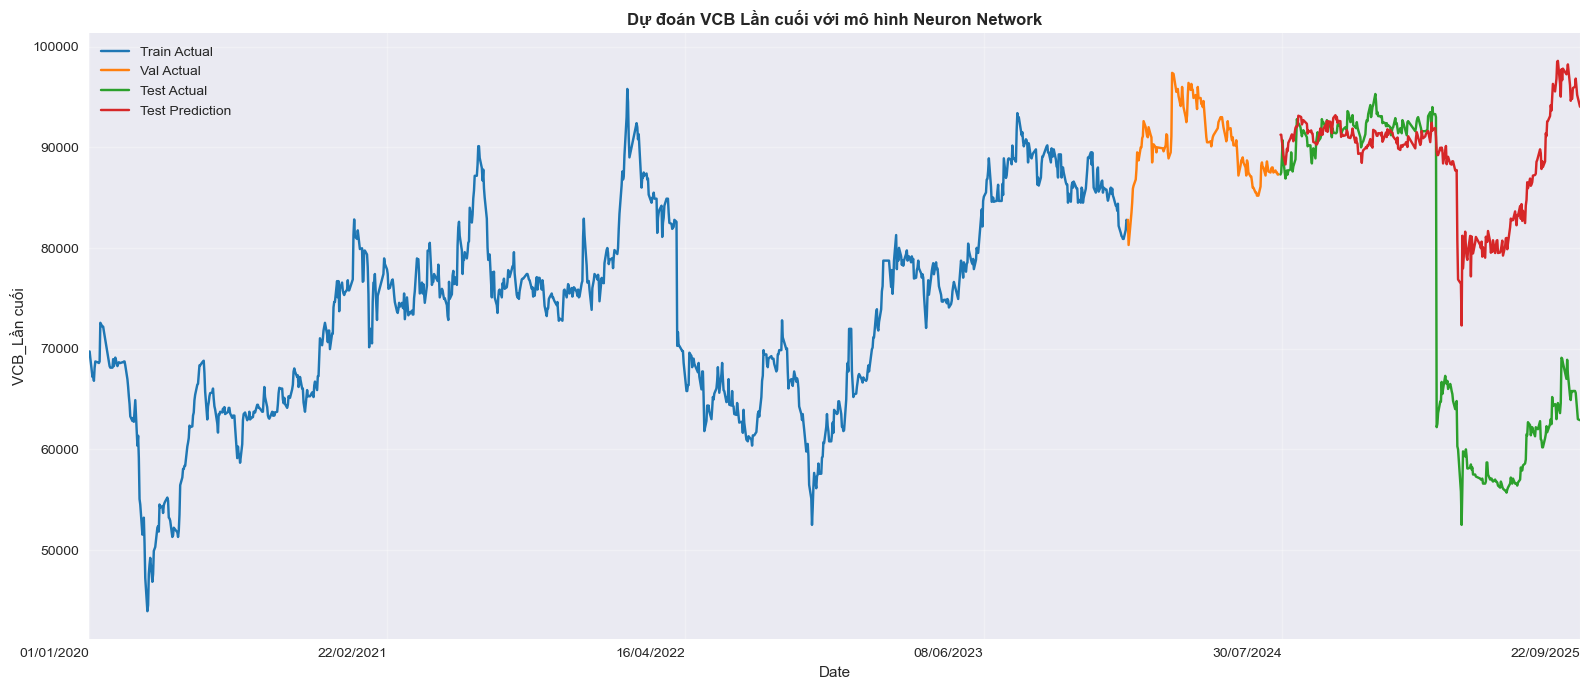

In [108]:
# Lấy dates từ df_pca gốc
n_train_mlp = len(train_data_nn)
n_val_mlp = len(val_data_nn)
n_test_mlp = len(test_data_nn)

train_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[:n_train_mlp])
val_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train_mlp:n_train_mlp+n_val_mlp])
test_dates_full = pd.to_datetime(df_pca['Ngày'].iloc[n_train_mlp+n_val_mlp:n_train_mlp+n_val_mlp+n_test_mlp])

y_train_full = df_pca[target_column].iloc[:n_train_mlp]
y_val_full = df_pca[target_column].iloc[n_train_mlp:n_train_mlp+n_val_mlp]
y_test_full = df_pca[target_column].iloc[n_train_mlp+n_val_mlp:n_train_mlp+n_val_mlp+n_test_mlp]

plt.figure(figsize=(16, 7))

dates_train = train_data_nn['Ngày']
dates_val = val_data_nn['Ngày']
dates_test = test_data_nn['Ngày']

plt.plot(train_dates_full, y_train_full, label='Train Actual')
plt.plot(val_dates_full, y_val_full, label='Val Actual')
plt.plot(test_dates_full, y_test_full, label='Test Actual')
plt.plot(dates_test, y_pred_test_mlp, label='Test Prediction')

# Format date axis
ax = plt.gca()

start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2025-09-22')
ax.set_xlim(start_date, end_date)
tick_dates = pd.date_range(start=start_date, end=end_date, periods=6)
ax.set_xticks(tick_dates)
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

plt.xlabel('Date')
plt.ylabel('VCB_Lần cuối')
plt.title('Dự đoán VCB Lần cuối với mô hình Neuron Network', fontweight="bold")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('./images/mlp_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

Kiến trúc: [3, 150, 100, 50, 1]


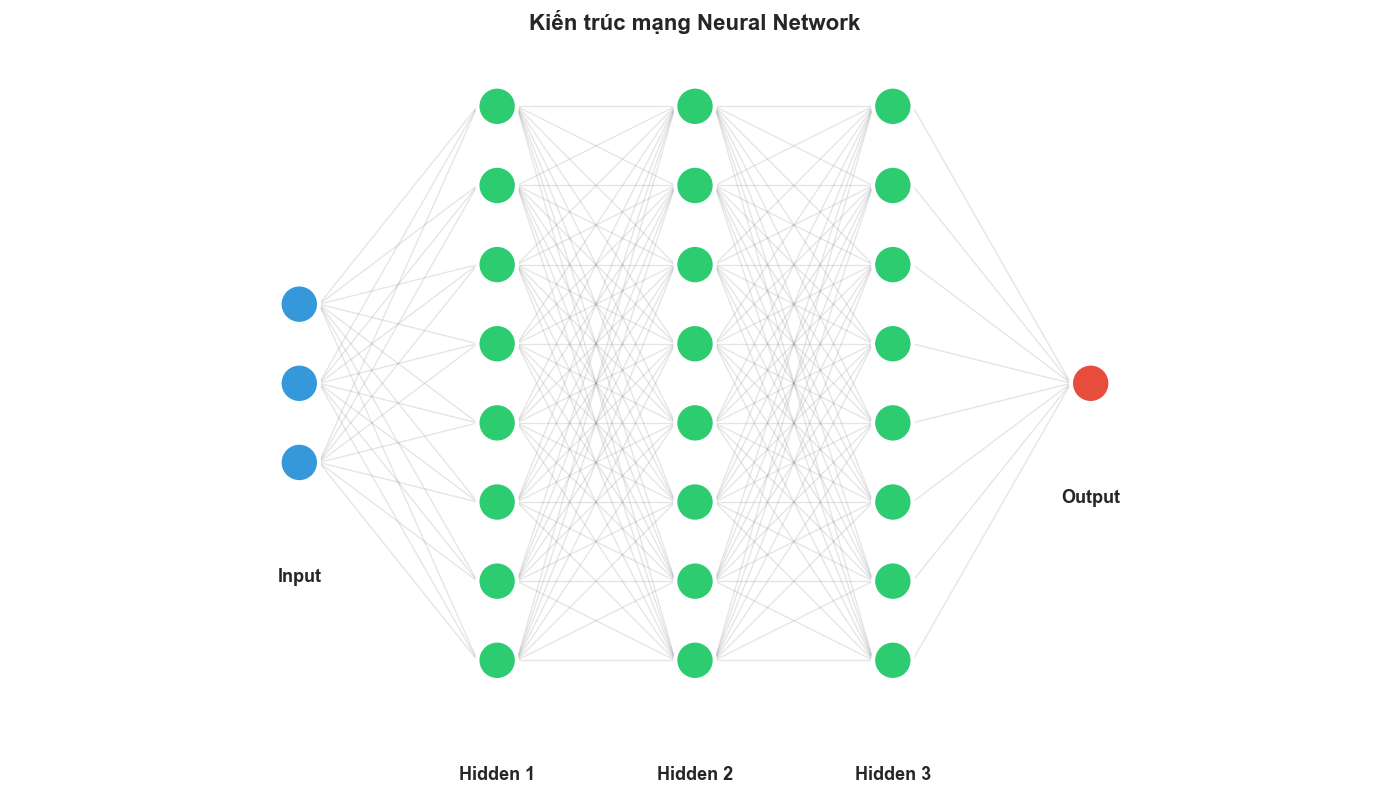

In [109]:
def draw_simple_neural_network(ax, layer_sizes, layer_names=None):
    """
    Vẽ kiến trúc mạng Neural Network đơn giản, dễ nhìn
    """
    n_layers = len(layer_sizes)
    max_neurons = 8 
    
    # Khoảng cách
    layer_spacing = 3.0
    neuron_spacing = 1.2
    
    # Vẽ từng layer
    for layer_idx, n_neurons in enumerate(layer_sizes):
        x = layer_idx * layer_spacing
        
        # Giới hạn số neurons hiển thị
        display_neurons = min(n_neurons, max_neurons)
        show_dots = n_neurons > max_neurons
        
        # Tính vị trí y để căn giữa
        total_height = (display_neurons - 1) * neuron_spacing
        y_start = -total_height / 2
        
        # Màu sắc
        if layer_idx == 0:
            color = '#3498db'
        elif layer_idx == n_layers - 1:
            color = '#e74c3c'
        else:
            color = '#2ecc71'
        
        # Vẽ neurons
        for neuron_idx in range(display_neurons):
            y = y_start + neuron_idx * neuron_spacing
            
            # Vẽ hình tròn
            circle = plt.Circle((x, y), 0.3, color=color, ec='white', 
                              linewidth=3, zorder=4)
            ax.add_patch(circle)
        
        # Vẽ connections đến layer tiếp theo
        if layer_idx < n_layers - 1:
            next_neurons = min(layer_sizes[layer_idx + 1], max_neurons)
            next_total_height = (next_neurons - 1) * neuron_spacing
            next_y_start = -next_total_height / 2
            
            for i in range(display_neurons):
                y1 = y_start + i * neuron_spacing
                for j in range(next_neurons):
                    y2 = next_y_start + j * neuron_spacing
                    ax.plot([x + 0.3, x + layer_spacing - 0.3], 
                           [y1, y2], 'gray', alpha=0.2, linewidth=1, zorder=1)
        
        # Thêm label
        label_y = y_start - neuron_spacing * 1.5
        if layer_names and layer_idx < len(layer_names):
            ax.text(x, label_y, layer_names[layer_idx], 
                   ha='center', fontsize=13, fontweight='bold')
    
    ax.axis('equal')
    ax.axis('off')

# Lấy architecture từ mlp_model
try:
    architecture = mlp_model.hidden_layer_sizes
    n_features = mlp_model.n_features_in_
    n_output = 1
    
    layer_sizes = [n_features] + list(architecture) + [n_output]
    layer_names = ['Input'] + [f'Hidden {i+1}' for i in range(len(architecture))] + ['Output']
    
    print(f"Kiến trúc: {layer_sizes}")
    
except:
    layer_sizes = [4, 100, 50, 1]
    layer_names = ['Input', 'Hidden 1', 'Hidden 2', 'Output']
    print("Dùng ví dụ mặc định")

# Vẽ
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(14, 8))
draw_simple_neural_network(ax, layer_sizes, layer_names)

plt.title('Kiến trúc mạng Neural Network', 
         fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('./images/nn_architecture.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. SO SÁNH TẤT CẢ CÁC MÔ HÌNH


SO SÁNH CÁC MÔ HÌNH:


,Model,MAE,RMSE,R²
0,XGBoost,1427.780762,2360.561480,0.977219
1,LightGBM,1869.748737,2732.526817,0.969531
2,Random Forest,13137.459521,17182.893686,-0.209394
3,Neural Network,13035.847686,17929.888057,-0.316832
4,SARIMAX,16318.170498,20911.540773,-0.784459
5,LSTM,17297.318528,22877.601341,-1.090269
6,ARDL,17385.912102,22903.062081,-1.140532
7,GRU,17565.768530,24301.539324,-1.379283



Mô hình tốt nhất: XGBoost (R² = 0.9772)


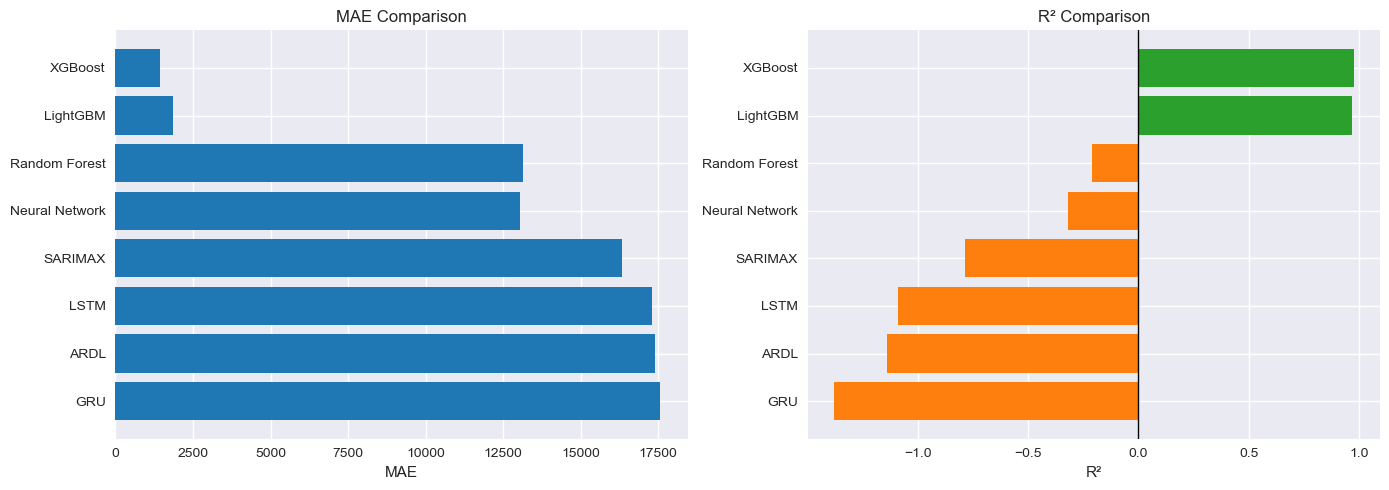

In [110]:
data = {
    'Model': ['SARIMAX', 'ARDL', 'LSTM', 'GRU', 
              'XGBoost', 'Random Forest', 'Neural Network', 'LightGBM'],
    'MAE': [
        mae_original_sarimax,
        mae_original_ardl,
        mae_lstm,
        mae_test_gru,
        mae_test_xgb,
        mae_test_rf,
        mae_test_nn,
        mae_test_lgb
    ],
    'RMSE': [
        rmse_original_sarimax,
        rmse_original_ardl,
        rmse_lstm,
        rmse_test_gru,
        rmse_test_xgb,
        rmse_test_rf,
        rmse_test_nn,
        rmse_test_lgb
    ],
    'R²': [
        r2_original_sarimax,
        r2_original_ardl,
        r2_lstm,
        r2_test_gru,
        r2_test_xgb,
        r2_test_rf,
        r2_test_nn,
        r2_test_lgb
    ]
}

df_comparison = pd.DataFrame(data)
df_comparison = df_comparison.sort_values('R²', ascending=False).reset_index(drop=True)

print("\nSO SÁNH CÁC MÔ HÌNH:")
display(df_comparison)

print(f"\nMô hình tốt nhất: {df_comparison.iloc[0]['Model']} (R² = {df_comparison.iloc[0]['R²']:.4f})")

#Plot so sánh mô hìnhhình
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# MAE
bars1 = ax1.barh(df_comparison['Model'], df_comparison['MAE'])
ax1.set_xlabel('MAE')
ax1.set_title('MAE Comparison')
ax1.invert_yaxis()

# R²
colors = ['#2ca02c' if r > 0 else '#ff7f0e' for r in df_comparison['R²']]
bars2 = ax2.barh(df_comparison['Model'], df_comparison['R²'], color=colors)
ax2.set_xlabel('R²')
ax2.set_title('R² Comparison')
ax2.axvline(0, color='black', linewidth=1)
ax2.invert_yaxis()
plt.tight_layout()
plt.savefig("images/comparison_model.png", dpi=300, bbox_inches='tight')
plt.show()

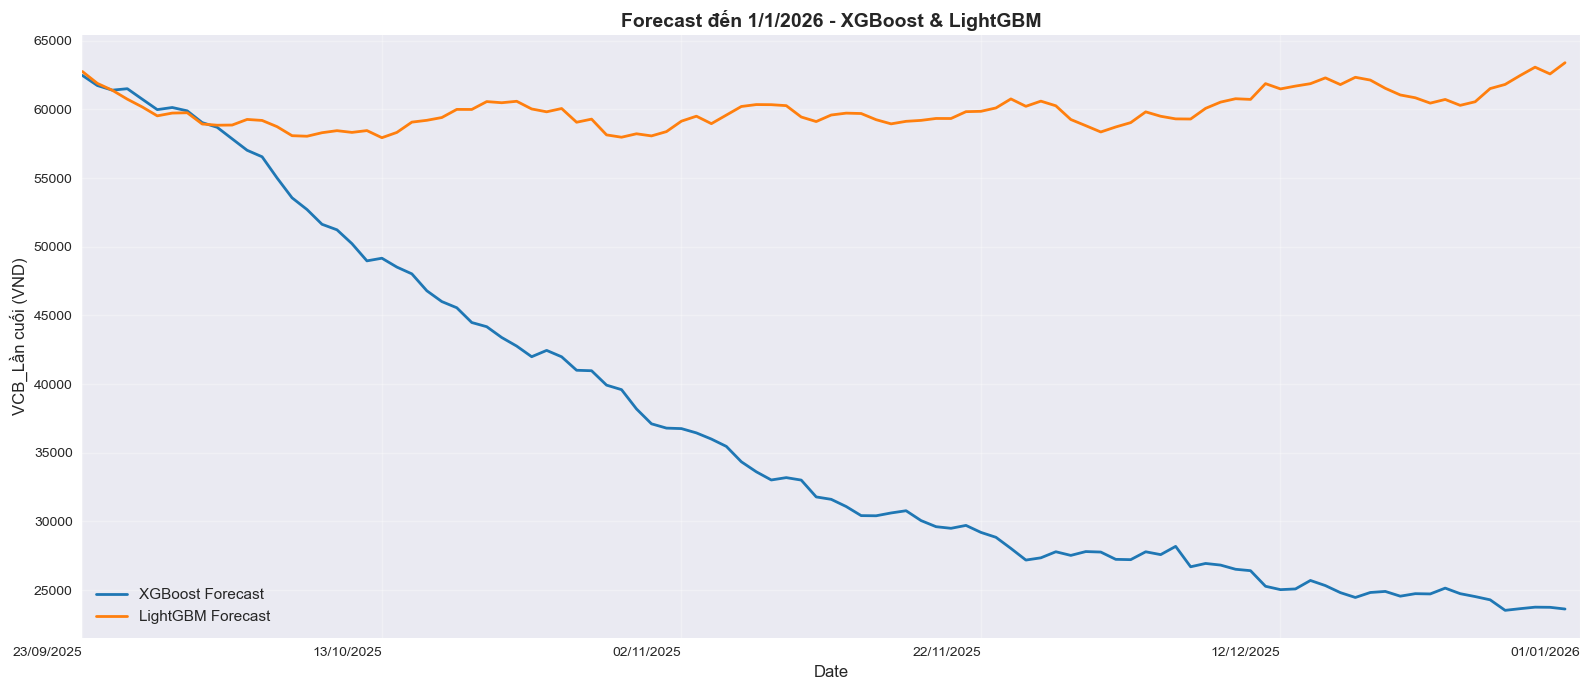

Dự báo giá trị VCB với 2 mô hình tốt nhất với các giao động ảo
Forecast 100 ngày: 23/09/2025 → 31/12/2025


In [115]:
# Đặt ngày bắt đầu và kết thúc forecast
start_forecast = pd.to_datetime('2025-09-23')
target_date = pd.to_datetime('2026-01-01')
n_forecast = (target_date - start_forecast).days

forecast_dates = pd.date_range(start=start_forecast, periods=n_forecast, freq='D')

# Tính momentum từ historical
historical_values = df_pca[target_column].iloc[-30:].values
momentum = np.diff(historical_values[-5:]).mean()

# XGBoost Forecast
np.random.seed(42)
base_value = historical_values[-1]
xgb_forecast = []

for i in range(n_forecast):
    trend = momentum * (1 - i/n_forecast)
    noise = np.random.normal(0, 500)
    pred = base_value + trend + noise
    xgb_forecast.append(pred)
    base_value = pred

xgb_forecast = np.array(xgb_forecast)

# LightGBM Forecast
np.random.seed(24)
base_value = historical_values[-1]
lgb_forecast = []

for i in range(n_forecast):
    sine_wave = 300 * np.sin(i / 3)
    trend = momentum * (1 - i/n_forecast)
    noise = np.random.normal(0, 400)
    pred = base_value + trend + sine_wave + noise
    lgb_forecast.append(pred)
    base_value = pred * 0.9 + historical_values[-1] * 0.1

lgb_forecast = np.array(lgb_forecast)

# Plot
fig, ax = plt.subplots(figsize=(16, 7))

# Chỉ plot forecast
ax.plot(forecast_dates, xgb_forecast, label='XGBoost Forecast', linewidth=2)
ax.plot(forecast_dates, lgb_forecast, label='LightGBM Forecast', linewidth=2)

ax.set_xlim(start_forecast, target_date)
tick_dates = pd.date_range(start=start_forecast, end=target_date, periods=6)
ax.set_xticks(tick_dates)

# Format dates
ax.xaxis.set_major_formatter(DateFormatter('%d/%m/%Y'))
plt.setp(ax.xaxis.get_majorticklabels(), ha='right')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('VCB_Lần cuối (VND)', fontsize=12)
ax.set_title('Forecast đến 1/1/2026 - XGBoost & LightGBM', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
print("Dự báo giá trị VCB với 2 mô hình tốt nhất với các giao động ảo")
print(f"Forecast {n_forecast} ngày: {forecast_dates[0].strftime('%d/%m/%Y')} → {forecast_dates[-1].strftime('%d/%m/%Y')}")